# Expediting Car Evaluations with ML 
###  Data Science and Advanced Analytics
###  Machine Learning 1st Phase Delivery

**Group 18**  
- Diogo Tibério         20250341
- José Montez           20250351
- Henrique Figueiredo   20250433
- Sebastião Jerónimo    20240660


<a id="index"></a>
## Index

1. [Introduction](#introduction)  
   - 1.1. [Project Overview](#project_overview)  
   - 1.2. [Import Libraries & Environment Setup](#import_libraries)  
   - 1.3. [Dataset Description](#dataset_description)  
      - 1.3.1. [Dataset Import & Metadata Overview](#dataset_import)  

2. [Exploratory Data Analysis (EDA)](#eda)  
   - 2.1. [Descriptive Statistics](#descriptive_statistics)  
   - 2.2. [Univariate Analysis](#univariate_analysis)  
   - 2.3. [Multivariate Analysis](#multivariate_analysis)  
   - 2.4. [Target Analysis](#target_analysis)  

3. [Data Cleaning and Preparation](#data_preparation)  
   - 3.1. [Handling Missing Values](#handling_missing_values)  
   - 3.2. [Outlier Detection and Treatment](#outliers)  
   - 3.3. [Categorical Variables: Standardization & Encoding](#categorical_encoding)  
   - 3.4. [Feature Engineering](#feature_engineering)  
   - 3.5. [Scaling & Normalization](#data_scaling)  

4. [Feature Selection](#feature_selection)  
   - 4.1. [Feature Selection Strategy](#selection_strategy)  
   - 4.2. [Implementation and Results](#selection_implementation)  
   - 4.3. [Final Feature Set Justification](#feature_justification)  

5. [Model Building and Evaluation](#model_building)  
   - 5.1. [Problem Definition & Type](#problem_type)  
   - 5.2. [Algorithm Selection](#algorithm_selection)  
   - 5.3. [Model Training and Prediction](#model_training)  
   - 5.4. [Model Assessment Strategy & Performance Metrics](#assessment_strategy)  
   - 5.5. [Interpretation of Results](#performance_metrics)  

6. [Conclusion and Next Steps](#conclusion)  
   - 6.1. [Key Findings](#key_findings)  
   - 6.2. [Limitations](#limitations)  
   - 6.3. [Recommendations / Future Work](#future_work)  




To Do:

Check M4 model performance
Neural Networl

<hr>
<a class="anchor" id="introduction"></a>

# 1. Introduction

Cars 4 You is an online platform for selling cars from multiple brands.

The company aims to automate the car evaluation process by developing a predictive model capable of estimating a car´s price based on user-provided information. The main goal is to eliminate the need for a physical inspection by a mechanic.

The objective of this project is to design, implement, and validate a model capable of providing accurate car price predictions to support Cars 4 You’s online evaluation process.

<hr>
<a class="anchor" id="project_overview"></a>

## 1.1. Project Overview 

As stated in the project proposal the company operates in a highly competitive used-car market, where any inefficiency in the business model can be exploited by competitors. At present, Cars 4 You faces a major bottleneck: rapid business growth has increased pressure on the evaluation workflow, which still depends on a limited network of mechanics. As a result, the current evaluation process is no longer capable of meeting the business needs.

To address this challenge, the company has decided to adopt a data-driven predictive modeling solution. If implemented correctly, this approach has the potential to become a major competitive advantage.

The project follows a CRISP-DM methodology for model development and evaluation. 


To address concerns regarding the model’s generalization capacity, a holdout set is initially used to obtain preliminary results, while cross-validation (CV) is subsequently applied to confirm robustness and assess overall generalization performance.

**Pipeline Diagram**

<hr>
<a class="anchor" id="import_libraries"></a>

## 1.2. Import Libraries & Environment Setup

The project leverages several Python libraries, with pandas and scikit-learn being the main tools for data manipulation, cleaning, preparation, and modeling. During the project, it was also necessary to use external libraries such as rapidfuzz for fuzzy string matching to standardize inconsistent text entries (e.g., car brands or models).


Multiple helper scripts were created to make the notebook more readable and less dense. The main notebook is structured as a comprehensive guide to the workflow followed throughout the project, presenting results and actionable insights in a logical sequence. Each helper file focuses on a specific task, indicated by its name, allowing the main notebook to remain readable and focused on analysis and modeling.

A .yml file will be provided for Conda users, along with a .txt file for non-Conda users, to facilitate environment setup.

In [462]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from rapidfuzz import process, fuzz
import re
import numpy as np
from typing import Sequence, Mapping, Optional

# Encoding and Scaling
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, RobustScaler, TargetEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from scipy.stats import gaussian_kde
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods and embedded methods 
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFECV, RFE

# Cross validation and splitting the data
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, PredefinedSplit
# Linear regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso

#Evaluation metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

In [463]:
%run fuzzy_matching.py
%run data_prep.py

<hr>
<a class="anchor" id="dataset_description"></a>

## 1.3. Dataset Description

To train the predictive model, Cars 4 You provided a dataset extracted from their 2020 database. Each record in the dataset corresponds to a car listing and includes a ground-truth price, as well as a set of features available at the time the user submits the evaluation form.

To test the model, an independent dataset containing cars not included in the training set is provided. This dataset includes the same descriptive features as the training set, but the ground-truth prices are not available. The trained models are used to predict prices for this dataset, and model performance is evaluated externally, for example via a Kaggle competition.

The available data includes the following attributes:

<hr>
<a class="anchor" id="dataset_import"></a>

### 1.3.1. Dataset Import & Metadata Overview

In [464]:
"""
    Loads a CSV datasets into pandas DataFrames.
    Handles missing file paths and encoding issues gracefully.
"""
try:
    train_car_data_original = pd.read_csv('data//train.csv')
    test_car_data_original = pd.read_csv('data//test.csv')
    sample_submission_car_data_original = pd.read_csv('data/sample_submission.csv')
# For when the file directory is not found
except FileNotFoundError as f:
    print(f"File not found: {f.filename}")
# For general errors
except Exception as e:
    print(f"An error occurred: {e}")

# Makes a preventive copy so it does not modify the original reference
train_car_data = train_car_data_original.copy()
test_car_data = test_car_data_original.copy()
sample_submission_car_data = sample_submission_car_data_original.copy()

| Feature | Description |
|---------|-------------|
| carID | An attribute that contains an identifier for each car |
| Brand | The car's main brand (e.g. Ford, Toyota) |
| model | The car model |
| year | The year of Registration of the Car |
| mileage | The total reported distance travelled by the car (in miles) |
| tax | The amount of road tax (in £) that, in 2020, was applicable to the car in question |
| fuelType | Type of Fuel used by the car (Diesel, Petrol, Hybrid, Electric) |
| mpg | Average Miles per Gallon |
| engineSize | Size of Engine in liters (Cubic Decimeters) |
| paintQuality% | The mechanic's assessment of the cars' overall paint quality and hull integrity (filled by the mechanic during evaluation) |
| previousOwners | Number of previous registered owners of the vehicle |
| hasDamage | Boolean marker filled by the seller at the time of registration stating whether the car is damaged or not |
| price | The car's price when purchased by Cars 4 You (in £) |

From the metadata description, the only remark that arises is that both mileage and mpg are represented using imperial units (miles and miles per gallon), while engineSize is given in liters (cubic decimeters), which is the standard international notation for engine capacity.

Additionally, the fact that the price and tax columns are in GBP suggests that the dataset refers to the UK market, which also explains the use of imperial units for mileage and mpg.

Besides these two remarks, all other variables appear well-structured with clear and descriptive names. One minor adjustment is recommended: standardize the Brand column name to lowercase (brand) for consistency, as it is the only column with an initial capital letter.

In [465]:
print("Train dataset:")
print(train_car_data.shape)

print("Test dataset:")
print(test_car_data.shape)

print("Samples submission dataset:")
print(sample_submission_car_data.shape)

Train dataset:
(75973, 14)
Test dataset:
(32567, 13)
Samples submission dataset:
(32567, 2)


<hr>
<a class="anchor" id="eda"></a>

# 2. Exploratory Data Analysis (EDA) 

In this section, we will explore the dataset to understand its structure, distributions, and relationships between variables. The goal is not only to describe the data but also to identify potential issues that should be addressed during the Data Cleaning and Preparation step.

For this step, only the training data will be considered, as this is the dataset used for model building and training.The main concern with joining datasets at this stage is information from the test set inadvertently biasing decisions. Any cleaning and preprocessing steps identified based on the training data will also be applied to the test data to ensure a functional model and accurate evaluation.

<hr>
<a class="anchor" id="descriptive_statistics"></a>

### 2.1. Descriptive Statistics

In [466]:
train_car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


The `tax` and `mpg` columns have high number of missing entries, roughly 7,000 each. Additionally, certain columns have inconsistent data types given the metadata description. For instance, `year` and `tax` are represented as floats instead of integers, and `hasDamage` is stored as a float instead of a boolean.

To address missing values, numerical features will be imputed using `KNNImputer`. Categorical features, given their relatively low number of missing entries, will be filled using the mode of each respective variable.

In [467]:
train_car_data.describe().T

count          mean           std           min       25%  \
carID           75973.0  37986.000000  21931.660338      0.000000  18993.00   
year            74482.0   2017.096611      2.208704   1970.000000   2016.00   
price           75973.0  16881.889553   9736.926322    450.000000  10200.00   
mileage         74510.0  23004.184088  22129.788366 -58540.574478   7423.25   
tax             68069.0    120.329078     65.521176    -91.121630    125.00   
mpg             68047.0     55.152666     16.497837    -43.421768     46.30   
engineSize      74457.0      1.660136      0.573462     -0.103493      1.20   
paintQuality%   74449.0     64.590667     21.021065      1.638913     47.00   
previousOwners  74423.0      1.994580      1.472981     -2.345650      1.00   
hasDamage       74425.0      0.000000      0.000000      0.000000      0.00   

                    50%      75%            max  
carID           37986.0  56979.0   75972.000000  
year             2017.0   2019.0    2024.121759  
price           14699.0  20950.0  159999.000000  
mileage         17300.0  32427.5  323000.000000  
tax               145.0    145.0     580.000000  
mpg                54.3     62.8     470.800000  
engineSize          1.6      2.0       6.600000  
paintQuality%      65.0     82.0     125.594308  
previousOwners      2.0      3.0       6.258371  
hasDamage           0.0      0.0       0.000000

**Correction of Data Types and Discrete Variables** <br>

As mentioned earlier, based on the metadata, `year` and `previousOwners` are discrete variables and should not be stored as floats. Therefore, the values of both variables will be rounded and converted to integers. For the `year` variable, given that the dataset contains cars up to 2020, any values greater than 2020 will be considered invalid and converted to `Null`.

There is also a case to be made that `engineSize` can be treated as a discrete variable. While engine size can vary continuously, in practice, vehicles have a limited set of standard engine categories (e.g., 1.0L, 1.2L, 1.4L, 2.0L, etc.).

**Correction of Data Types and Discrete Variables** <br>

A lot of the numerical variables have negative values when the provided description these shouldnt be recorded mileage, tax, mpg, engineSize, previousOwners for all these variables these values will be considered invalid and converted into null. Also in the case of paintWuality as it is a percentage values over 100% will be considered invalid and will receive the same treatment. 


Several numerical variables contain negative values, which are not valid according to the dataset description and common sense. This includes `mileage`, `tax`, `mpg`, `engineSize`, and `previousOwners`. These invalid values will be converted to `Null`.

For `paintQuality%`, as it represents a percentage, any values above 100% will also be considered invalid and treated as `Null`.

**Correction of Data Types and Discrete Variables** <br>

The distribution of numerical variables reveals a big gap between the maximum values and the 75th percentile for variables such as `mpg`, ``mileage``, and ``price``. The presence of extreme values far from the mean is reflected in the high standard deviations, suggesting the presence of outliers. Specific strategies to handle these outliers will be discussed later in the notebook.

**hasDamage** <br>

All values are 0. Since it is constant, it provides no information and therefore has no predictive power. This feature will be removed from the dataset. 

In [468]:
train_car_data.describe(include="object").T

count unique     top   freq
Brand         74452     72    Ford  14808
model         74456    735   Focus   6353
transmission  74451     40  Manual  38050
fuelType      74462     34  Petrol  37995

**Fuel Type** <br>
The high number of unique categories in fuelType is unusual given the problem specifications. Further analysis is needed to determine actionables.

**Missing Values** <br>
Each categorical feature has roughly 1,000 missing entries. To decide on the best approach for imputation or other handling strategies, it is important to understand the nature of these missing values—whether they are missing at random, systematic, or due to input errors.

**Brand and Model Distribution** <br>
Approximately 20% of the cars in the dataset are Fords, with the Ford Focus being the most frequently represented model.


<hr>
<a class="anchor" id="univariate_analysis"></a>

### 2.2. Univariate Analysis

In [469]:
col_n, col_c = colTypes(train_car_data)

Numeric Cols: ['carID', 'engineSize', 'mileage', 'mpg', 'paintQuality%', 'price', 'tax', 'year']
Categorical Cols: ['Brand', 'model', 'transmission', 'fuelType', 'previousOwners', 'hasDamage']


In [470]:
# Remove columns from numerical list if they are misclassified due to inconsistencies

for col in ["carID", "year"]:
    if col in col_n:
        col_n.remove(col) 

if "year" not in col_c:
    col_c.append("year") 

<hr>
<a class="anchor" id="descriptive_statistics"></a>

#### 2.2.1. Unique Values

In [471]:
for col in col_n:
    print(f"\n--- {col} ---")
    train_car_data[col].unique()


--- engineSize ---

--- mileage ---

--- mpg ---

--- paintQuality% ---

--- price ---

--- tax ---


This analysis reveals data quality issues that already have been mentioned above, negative values, float to int conversions and extreme values that in some cases are not possible.

The ``engineSize`` variable displays a large number of high-precision decimal values (e.g., 2.61964142, 0.15452932, 3.73923548). In real automotive datasets, engine displacement expressed in liters is almost always rounded to one decimal place, because liters results from dividing cubic centimeters by 1000 (e.g., 1995 cc corresponds to 2.0 L). Therefore, these multi-decimal engine sizes are likely due to data corruption or unit conversion errors, and require correction (e.g., rounding to 1 decimal or replacing invalid values based on nearest common displacements).

In [472]:
for col in col_c:
    print(f"\n--- {col} ---")
    print(train_car_data[col].unique())


--- Brand ---
['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'FOR'
 'mercedes' 'Hyundai' 'w' 'ord' 'MW' 'bmw' nan 'yundai' 'BM' 'Toyot' 'udi'
 'Ope' 'AUDI' 'V' 'opel' 'pel' 'For' 'pe' 'Mercede' 'audi' 'MERCEDES'
 'OPEL' 'koda' 'FORD' 'Hyunda' 'W' 'Aud' 'vw' 'hyundai' 'skoda' 'ford'
 'TOYOTA' 'ercedes' 'oyota' 'toyota' 'SKODA' 'Skod' 'HYUNDAI' 'kod' 'v'
 'for' 'SKOD' 'aud' 'KODA' 'PEL' 'yunda' 'or' 'UDI' 'OYOTA' 'HYUNDA' 'mw'
 'OPE' 'mercede' 'ERCEDES' 'ercede' 'TOYOT' 'MERCEDE' 'ORD' 'ud' 'ope'
 'AUD' 'hyunda' 'skod' 'toyot']

--- model ---
[' Golf' ' Yaris' ' Q2' ' FIESTA' ' 2 Series' '3 Series' ' A3' ' Octavia'
 ' Passat' ' Focus' ' Insignia' ' A Clas' ' Q3' ' Fabia' ' A Class' ' Ka+'
 ' 3 Series' ' GLC Class' ' I30' ' C Class' ' Polo' ' E Class' ' C Clas'
 ' Q5' ' Up' ' Fiesta' ' C-HR' ' Mokka X' ' Corsa' ' Astra' ' TT'
 ' 5 Series' ' Aygo' ' 4 Series' ' SLK' ' Viva' ' T-Roc' 'Focus'
 ' EcoSport' ' Tucson' ' EcoSpor' nan ' X-CLASS' ' CL Class' ' IX20'
 ' i20' ' Rapid'

**Categorical Variables Cleaning**

Most values in brand, model, transmission, and fuelType show clear signs of inconsistent or corrupted string entries. These inconsistencies include partial strings (“For”, “MW”), misspellings (“Hyunda”, “Pe”, “emi-Auto”), casing variations, leading/trailing whitespace etc.

To standardize these categories, we will address the inconsistencies using fuzzy matching, a technique that identifies similar but not identical strings based on a similarity score.


<hr>
<a class="anchor" id=""></a>

#### 2.2.2 Boxplots Numeric Variables

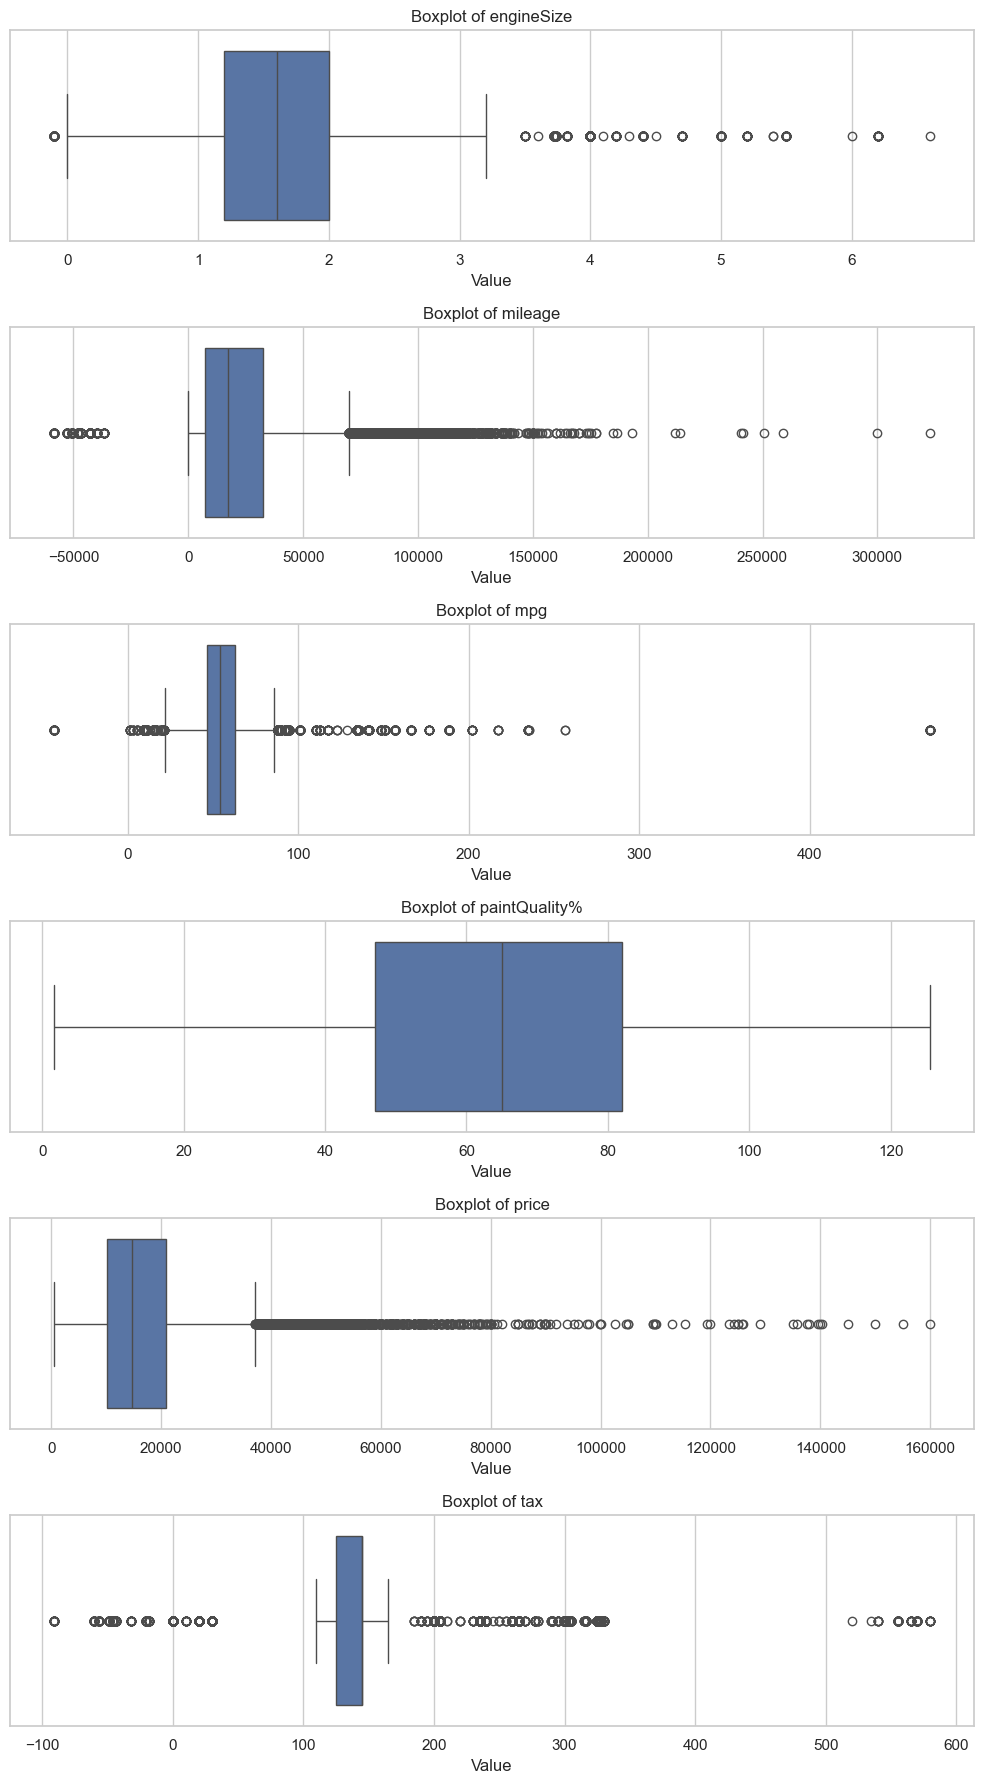

In [473]:
fig, axes = plt.subplots(nrows=len(col_n), ncols=1, figsize=(10, 3 * len(col_n)))

for ax, col in zip(axes, col_n):
    sns.boxplot(x=train_car_data[col], ax=ax, orient="h")
    ax.set_title(f"Boxplot of {col}", fontsize=12)
    ax.set_xlabel("Value")

plt.tight_layout()
plt.show()

**Outliers** <br>

Using the IQR method, the suspicions mentioned above are confirmed: numerical variables contain numerous outliers.

While the IQR method is effective at detecting statistical outliers, business knowledge allows us to define acceptable ranges for each variable. This ensures that only truly implausible or erroneous values are addressed, rather than removing legitimate extreme observations that may carry valuable information for model generalization.

A mask will be applied to each variable, defining a range of values considered acceptable based on business knowledge.


<hr>
<a class="anchor" id=""></a>

#### 2.2.3 Categorical Variables Countplots

C:\Users\henri\AppData\Local\Temp\ipykernel_22124\2740455548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_car_data, x=col, order=train_car_data[col].value_counts().index, palette="Set2")
C:\Users\henri\AppData\Local\Temp\ipykernel_22124\2740455548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_car_data, x=col, order=train_car_data[col].value_counts().index, palette="Set2")
C:\Users\henri\AppData\Local\Temp\ipykernel_22124\2740455548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_car_dat

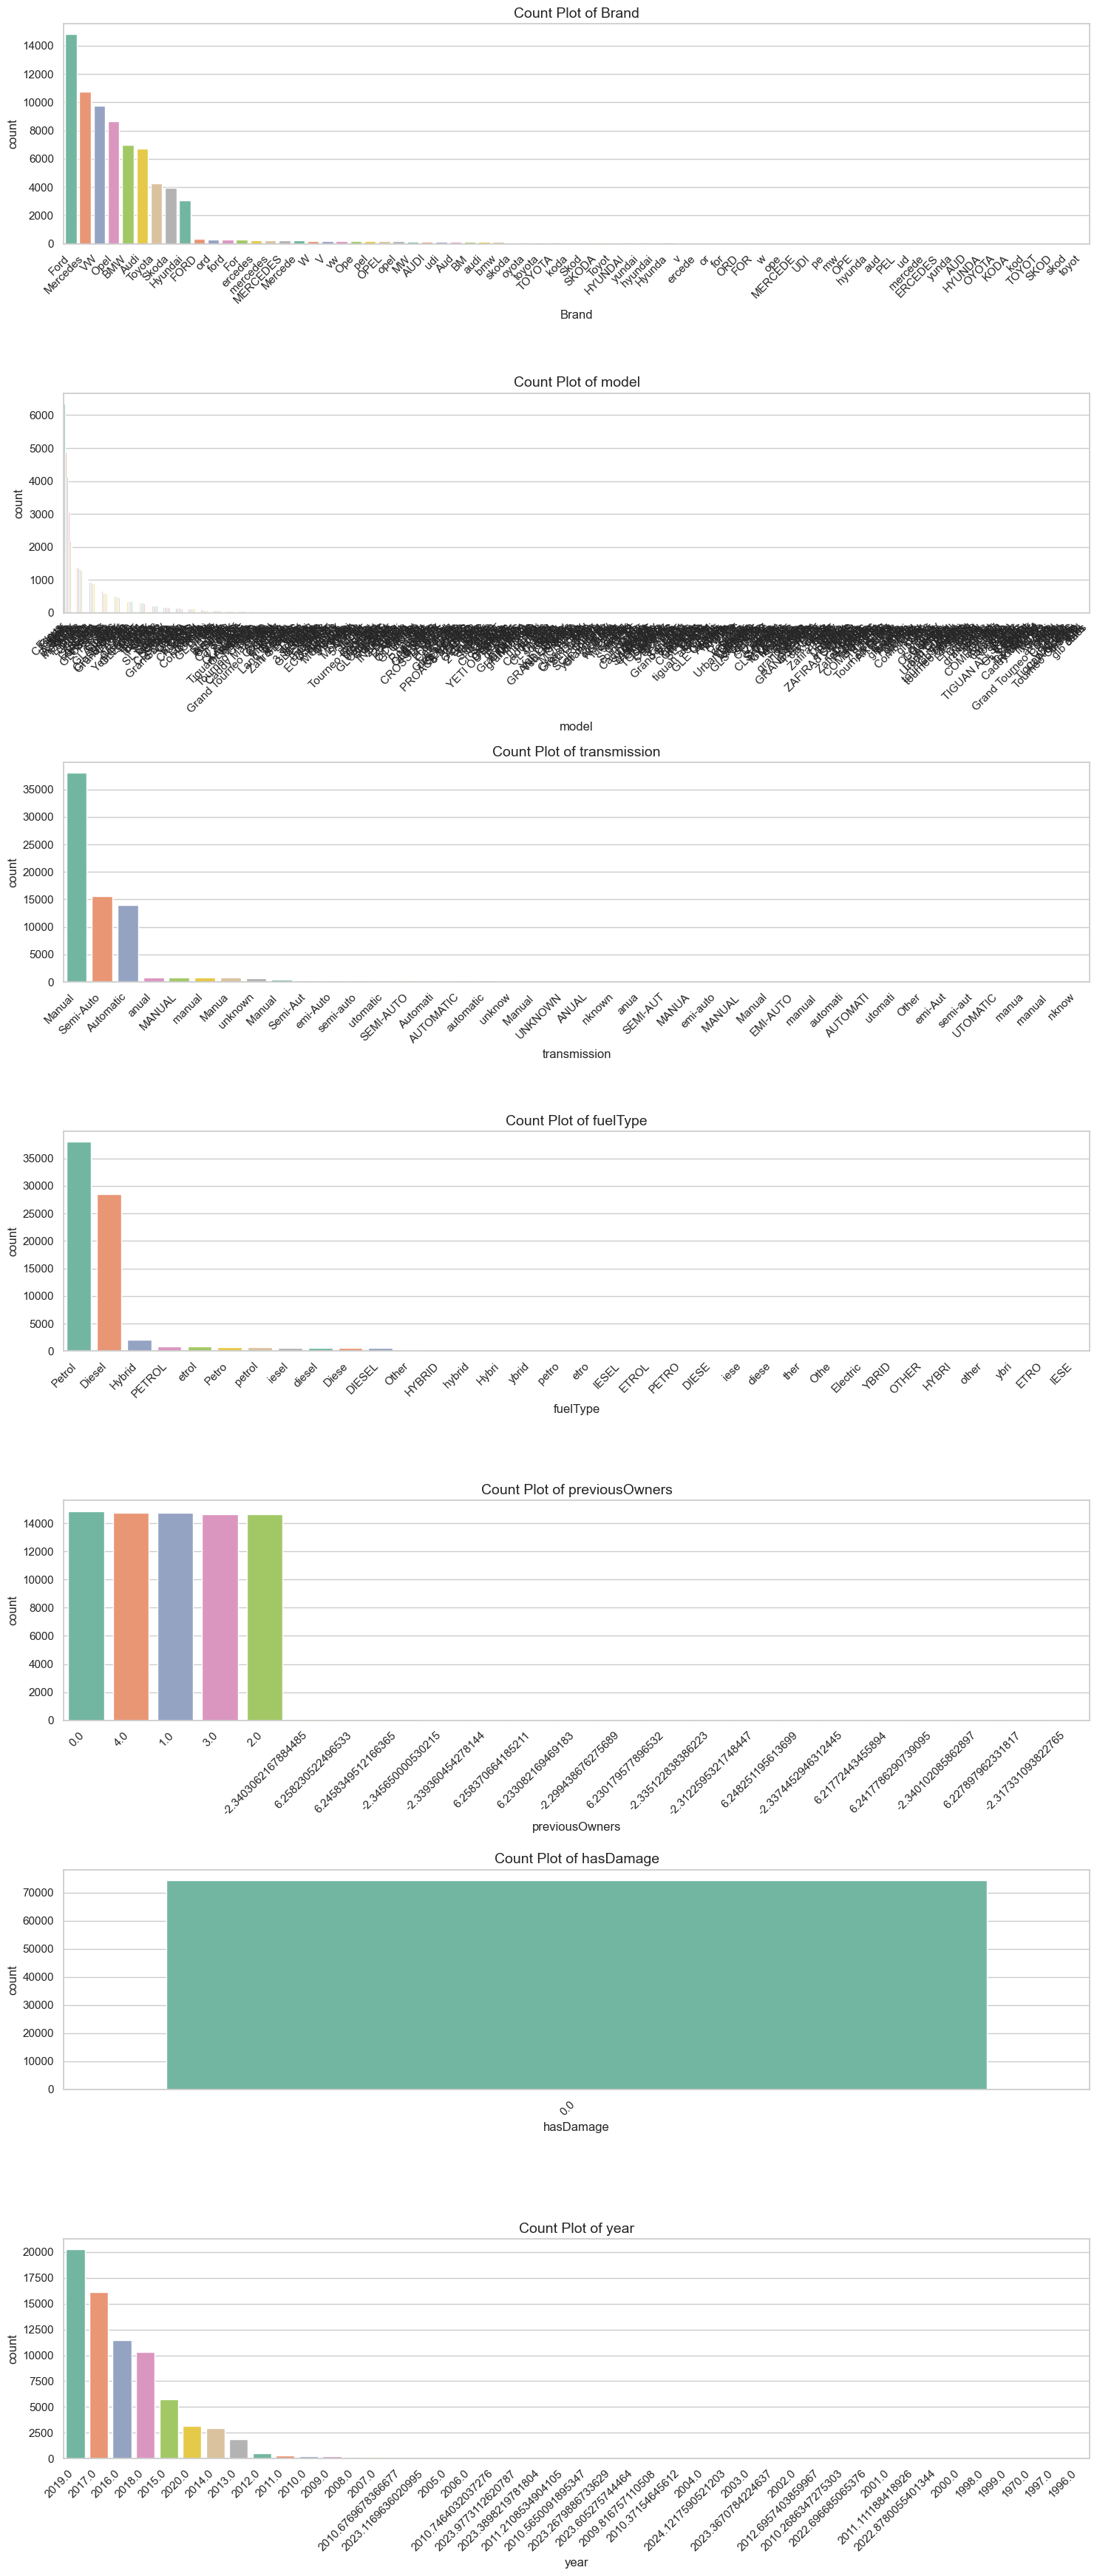

In [474]:
# Set overall style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5 * len(col_c)))

# Loop through categorical columns
for i, col in enumerate(col_c, 1):
    plt.subplot(len(col_c), 1, i)
    sns.countplot(data=train_car_data, x=col, order=train_car_data[col].value_counts().index, palette="Set2")
    plt.title(f'Count Plot of {col}', fontsize=14)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

At the moment, the count plots are difficult to interpret because of data inconsistencies. These issues need to be addressed before the plots can provide meaningful insights.

<hr>
<a class="anchor" id="data_preparation"></a>

#  3. Data Cleaning and Preparation

For easier comprehension and more readable code, the training and test datasets will be temporarily joined. This allows consistent cleaning and feature engineering across both datasets. However, care must be taken to prevent data leakage

In [475]:
train_car_data["train"] = True
test_car_data["train"] = False

df = pd.concat([train_car_data, test_car_data], ignore_index=True)
df

carID     Brand      model    year    price transmission  \
0        69512        VW       Golf  2016.0  22290.0    Semi-Auto   
1        53000    Toyota      Yaris  2019.0  13790.0       Manual   
2         6366      Audi         Q2  2019.0  24990.0    Semi-Auto   
3        29021      Ford     FIESTA  2018.0  12500.0        anual   
4        10062       BMW   2 Series  2019.0  22995.0       Manual   
...        ...       ...        ...     ...      ...          ...   
108535  105775        VW     Tiguan  2017.0      NaN       Manual   
108536   81363       BMW         X2  2020.0      NaN    Automatic   
108537   76833      Audi         Q5  2019.0      NaN    Semi-Auto   
108538   91768  Mercedes    A Class  2019.0      NaN       Manual   
108539   99627    Toyota      Yaris  2017.0      NaN    Automatic   

            mileage fuelType    tax        mpg  engineSize  paintQuality%  \
0       28421.00000   Petrol    NaN  11.417268         2.0           63.0   
1        4589.00000   Petrol  145.0  47.900000         1.5           50.0   
2        3624.00000   Petrol  145.0  40.900000         1.5           56.0   
3        9102.00000   Petrol  145.0  65.700000         1.0           50.0   
4        1000.00000   Petrol  145.0  42.800000         1.5           97.0   
...             ...      ...    ...        ...         ...            ...   
108535  27575.00000   Petrol  145.0  46.300000         1.4           94.0   
108536   1980.00000   Petrol  145.0  34.000000         2.0           39.0   
108537   8297.00000   Diesel  145.0  38.200000         2.0           88.0   
108538 -50755.21023   Petrol  145.0  28.500000         1.3           81.0   
108539  11071.00000   Petrol   30.0  58.000000         1.3           98.0   

        previousOwners  hasDamage  train  
0             4.000000        0.0   True  
1             1.000000        0.0   True  
2             4.000000        0.0   True  
3            -2.340306        0.0   True  
4             3.000000        0.0   True  
...                ...        ...    ...  
108535        1.000000        0.0  False  
108536        3.000000        0.0  False  
108537        4.000000        0.0  False  
108538        1.000000        0.0  False  
108539        4.000000        0.0  False  

[108540 rows x 15 columns]

In [476]:
df = df.set_index("carID")

<hr>
<a class="anchor" id=""></a>

##  3.1 Data Type Correction and Value Standardization

In [477]:
# no negative values in numerical columns 
df[col_n] = df[col_n].where(df[col_n] >= 0, np.nan)

In [478]:
df["previousOwners"] = df["previousOwners"].where(df["previousOwners"] >= 0, np.nan)

In [479]:
df["year"] = df["year"].where(df["year"] <= 2022, np.nan)

In [480]:
# Enforce int values for cols previousOwners, year. The values will be rouded to avoid incorrect or overestimarion of some values
df[["year", "previousOwners"]] = df[["year", "previousOwners"]].apply(np.floor).astype("int", errors="ignore")

In [481]:
# For now engine size will be rounded to decimal place
df['engineSize'] = df['engineSize'].round(1)

<hr>
<a class="anchor" id=""></a>

##  3.2 Fuzzy Matching Categorical Variables

In [482]:
brands_list = ["Volkswagen", "Toyota", "Audi", "Ford", "BMW", "Skoda", "Opel", "Mercedes", "Hyundai"]
brands_aliases = {"vw":"Volkswagen","v":"Volkswagen","merc":"Mercedes","bm":"BMW"}

transmissions_list = ["Manual","Automatic","Semi-Automatic", "Other", "Unkown"]
transmissions_alises = {"mt":"Manual","man":"Manual","auto":"Automatic","at":"Automatic","dsg":"Automatic"}

fueltype_list = ["Petrol", "Diesel", "Hybrid", "Electric", "Other"]

MODEL_BY_BRAND = {
    'Audi': ['A', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'Q', 'Q2', 'Q3', 'Q5', 'Q7', 'Q8', 'RS', 'RS3', 'RS4', 'RS5', 'RS6', 'S', 'S1', 'S3', 'S4', 'S5', 'S6', 'SQ2', 'SQ5', 'TT', 'e-tron'],
    'BMW': ['1 Series', '2 Series', '3 Serie', '3 SERIES', '3 Series', '4 Series', '5 Serie', '5 Series', '7 Series', '8 Series', 'M2', 'M3', 'M4', 'M5', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'Z4', 'i3', 'i4'],
    'Ford': ['B-MAX', 'C-MAX', 'Ecosport', 'Edge', 'Fiesta', 'Focus', 'Galaxy', 'Ka', 'Kuga', 'Mondeo', 'Mustang', 'Puma', 'S-MAX', 'Tourneo', 'Transit'],
    'Hyundai': ['Accent', 'Getz', 'I1', 'I10', 'I2', 'I20', 'I3', 'I30', 'I40', 'I80', 'I800', 'IONIQ', 'Kona', 'Santa Fe', 'Tucson'],
    'Mercedes': ['A-Class', 'AMG GT', 'B-Class', 'C-Class', 'CLA', 'CLK', 'CLS', 'Citan', 'E-Class', 'GLA', 'GLB', 'GLC', 'GLE', 'GLK', 'GLS', 'M-Class', 'S-Class', 'GLC-Class', 'SL', 'SLC', 'SLK', 'Sprinter', 'V-Class', 'Vaneo', 'Viano'],
    'Opel': ['Adam', 'Astra', 'Corsa', 'Crossland', 'Grandland', 'Insignia', 'Karl', 'Meriva', 'Mokka', 'Vectra', 'Zafira'],
    'Skoda': ['Citigo', 'Enyaq', 'Fabia', 'Kamiq', 'Karoq', 'Kodiaq', 'Octavia', 'Rapid', 'Roomster', 'Scala', 'Superb', 'Yeti'],
    'Toyota': ['Auris', 'Avensis', 'Aygo', 'C-HR', 'Camry', 'Corolla', 'GT86', 'RAV4', 'Verso', 'Yaris'],
    'Volkswagen': ['Arteon', 'Beetle', 'Bora', 'Caddy', 'CC', 'Crafter', 'Eos', 'Fox', 'Golf', 'Golf Plus', 'ID.3', 'ID.4', 'Jetta', 'Lupo', 'Passat', 'Phaeton', 'Polo', 'Scirocco', 'Sharan', 'T-Cross', 'T-Roc', 'Tiguan', 'Touareg', 'Touran', 'Transporter', 'Up'],
}

In [483]:
cleaner = FuzzyMatching(
    df=df,
    brand_list=brands_list,
    model_by_brand=MODEL_BY_BRAND,
    brand_aliases=brands_aliases,
    transmission_list=transmissions_list,
    fueltype_list=fueltype_list
)

In [484]:
print(cleaner.fuzzy_fix.__doc__)


        Cleans a single value using normalization, optional alias mapping,
        exact matching, and fuzzy matching.

        Args:
            raw_value (object): Original value to clean.
            valid_values (Sequence[str]): List of canonical valid values to match against.
            alias_map (Optional[Mapping[str, str]]): Optional mapping of aliases to canonical values.
            cutoff (int): Minimum fuzzy similarity score to accept a match.
            scorer: Fuzzy matching scoring function (default fuzz.WRatio).

        Returns:
            str or np.nan: Corrected canonical value or NaN if no match found.
        


In [485]:
cleaner.clean_column("Brand")
cleaner.clean_column("transmission")
cleaner.clean_column("fuelType")
cleaner.clean_modelCol("model", "Brand")

fuzzy_df = cleaner.df

fuzzy_df

Brand     model    year    price    transmission  mileage  \
carID                                                                    
69512   Volkswagen      Golf  2016.0  22290.0  Semi-Automatic  28421.0   
53000       Toyota     Yaris  2019.0  13790.0          Manual   4589.0   
6366          Audi        Q2  2019.0  24990.0  Semi-Automatic   3624.0   
29021         Ford    Fiesta  2018.0  12500.0          Manual   9102.0   
10062          BMW  2 Series  2019.0  22995.0          Manual   1000.0   
...            ...       ...     ...      ...             ...      ...   
105775  Volkswagen    Tiguan  2017.0      NaN          Manual  27575.0   
81363          BMW        X2  2020.0      NaN       Automatic   1980.0   
76833         Audi        Q5  2019.0      NaN  Semi-Automatic   8297.0   
91768     Mercedes   A-Class  2019.0      NaN          Manual      NaN   
99627       Toyota     Yaris  2017.0      NaN       Automatic  11071.0   

       fuelType    tax        mpg  engineSize  paintQuality%  previousOwners  \
carID                                                                          
69512    Petrol    NaN  11.417268         2.0           63.0             4.0   
53000    Petrol  145.0  47.900000         1.5           50.0             1.0   
6366     Petrol  145.0  40.900000         1.5           56.0             4.0   
29021    Petrol  145.0  65.700000         1.0           50.0             NaN   
10062    Petrol  145.0  42.800000         1.5           97.0             3.0   
...         ...    ...        ...         ...            ...             ...   
105775   Petrol  145.0  46.300000         1.4           94.0             1.0   
81363    Petrol  145.0  34.000000         2.0           39.0             3.0   
76833    Diesel  145.0  38.200000         2.0           88.0             4.0   
91768    Petrol  145.0  28.500000         1.3           81.0             1.0   
99627    Petrol   30.0  58.000000         1.3           98.0             4.0   

        hasDamage  train  
carID                     
69512         0.0   True  
53000         0.0   True  
6366          0.0   True  
29021         0.0   True  
10062         0.0   True  
...           ...    ...  
105775        0.0  False  
81363         0.0  False  
76833         0.0  False  
91768         0.0  False  
99627         0.0  False  

[108540 rows x 14 columns]

In [486]:
# If we know the model we should know the brand, rows with no Brand but model is present can be filled with correct value 
model_noBrand_index = fuzzy_df[df["Brand"].isna() & fuzzy_df["model"].notna()].index
len(model_noBrand_index)

2045

In [487]:
filled_df = findModel(fuzzy_df, MODEL_BY_BRAND)

A total of 2045 models without the respective brand were found and filled.


C:\Users\henri\AppData\Local\Temp\ipykernel_22124\792971582.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filled_df, x=col, order=filled_df[col].value_counts().index, palette="Set2")
C:\Users\henri\AppData\Local\Temp\ipykernel_22124\792971582.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filled_df, x=col, order=filled_df[col].value_counts().index, palette="Set2")
C:\Users\henri\AppData\Local\Temp\ipykernel_22124\792971582.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filled_df, x=col, order=filled_df[co

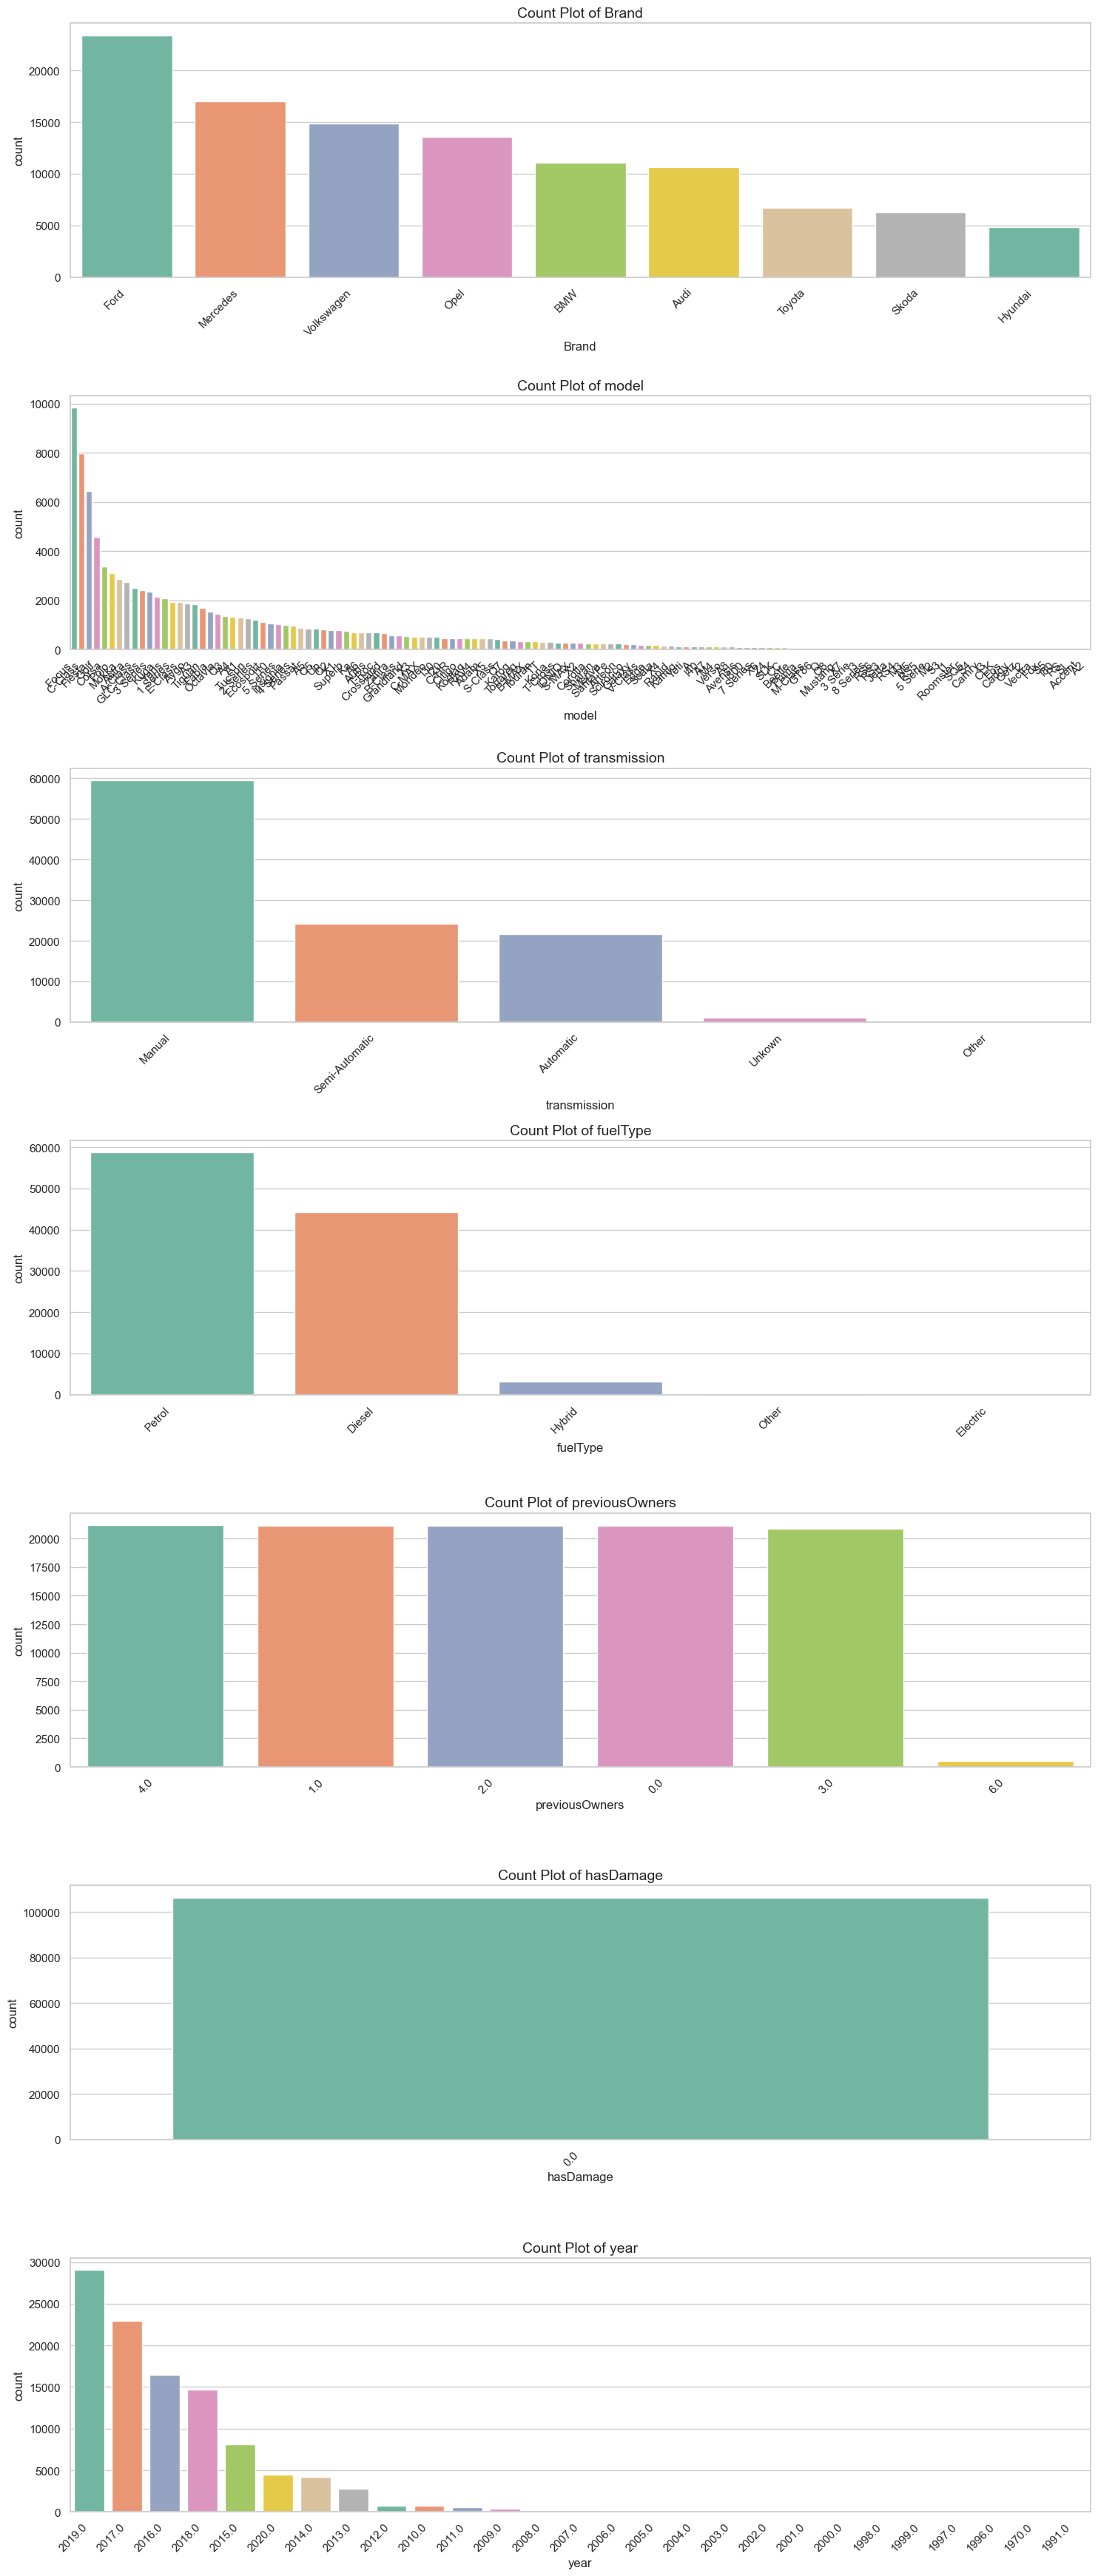

In [488]:
# Set overall style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5 * len(col_c)))

# Loop through categorical columns
for i, col in enumerate(col_c, 1):
    plt.subplot(len(col_c), 1, i)
    sns.countplot(data=filled_df, x=col, order=filled_df[col].value_counts().index, palette="Set2")
    plt.title(f'Count Plot of {col}', fontsize=14)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

<hr>
<a class="anchor" id=""></a>

##  3.3 Outliers Treatment

In this step, transformations will be applied only to the training data. The goal is to ensure the model is trained on a dataset free of extreme or implausible values, which could negatively affect learning. The test set, however, represents the real-world scenario that the model will encounter in production. Removing outliers from the test set would create an artificial evaluation scenario, so it will remain unchanged to properly assess the model’s generalization and robustness.

In [489]:
train_df = filled_df[filled_df["train"] == True]

conditions = {
    "price <= 100000": train_df["price"] <= 10000,
    "mileage 0–170000": train_df["mileage"].between(0, 170000),
    "tax 0–300": train_df["tax"].between(0, 300),
    "mpg 0–150": train_df["mpg"].between(0, 150),
    "engineSize 0–5": train_df["engineSize"].between(0, 5),
    "paintQuality 0–100": train_df["paintQuality%"].between(0, 100),
}


total = len(train_df)

for name, cond in conditions.items():
    removed = total - cond.sum()
    print(f"{name}: removed {removed} rows ({removed/total:.2%})")

price <= 100000: removed 57286 rows (75.40%)
mileage 0–170000: removed 1849 rows (2.43%)
tax 0–300: removed 8838 rows (11.63%)
mpg 0–150: removed 8183 rows (10.77%)
engineSize 0–5: removed 1671 rows (2.20%)
paintQuality 0–100: removed 1891 rows (2.49%)


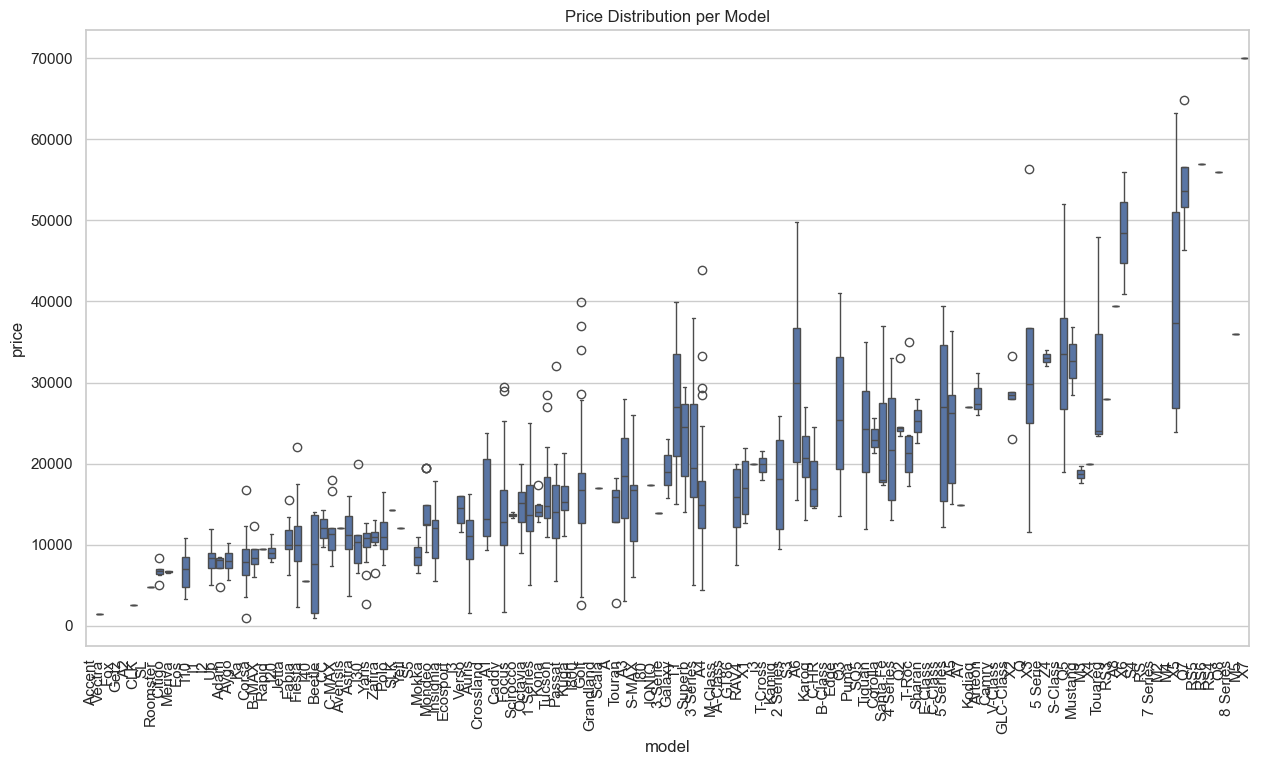

In [490]:
plt.figure(figsize=(15, 8))
# Sorting models by median price makes the plot much easier to read
order = train_df.groupby('model')['price'].median().sort_values().index

sns.boxplot(data=df, x='model', y='price', order=order)
plt.xticks(rotation=90)
plt.title("Price Distribution per Model")
plt.show()

In [491]:
mask = (
     (train_df["mileage"].between(0, 170000)   | train_df["mileage"].isna())
    & (train_df["tax"].between(0, 300)          | train_df["tax"].isna())
    & (train_df["mpg"].between(0.1, 150)        | train_df["mpg"].isna())
    & (train_df["engineSize"].between(0.1, 10)  | train_df["engineSize"].isna())

)

"""mask = (
    (df["train"] == True) 
    &
    (df["mileage"].between(0, 150_000) | train_df["mileage"].isna())
    &
    (df["tax"].between(0, 300) | train_df["tax"].isna())
    &
    (df["mpg"].between(0.1, 150)| train_df["mpg"].isna())
    &
    (df["engineSize"].between(0.1, 5) | train_df["engineSize"].isna())
)"""

train_no_outliers = train_df[mask]
test_no_outliers  = filled_df[filled_df["train"] == False]

df_no_outliers = pd.concat([train_no_outliers, test_no_outliers], axis=0)

In [492]:
print("In the aftermath of outlier treatment:")
print(f"Training Set: {len(train_df) - len(train_no_outliers)} observations were eliminated")

In the aftermath of outlier treatment:
Training Set: 944 observations were eliminated


<hr>
<a class="anchor" id=""></a>

##  3.4 Missing Values


In [493]:
train_no_outliers.isna().sum()

Brand               89
model             4524
year              1830
price                0
transmission      1494
mileage           1809
fuelType          1497
tax               8268
mpg               7928
engineSize        1582
paintQuality%     1504
previousOwners    1900
hasDamage         1528
train                0
dtype: int64

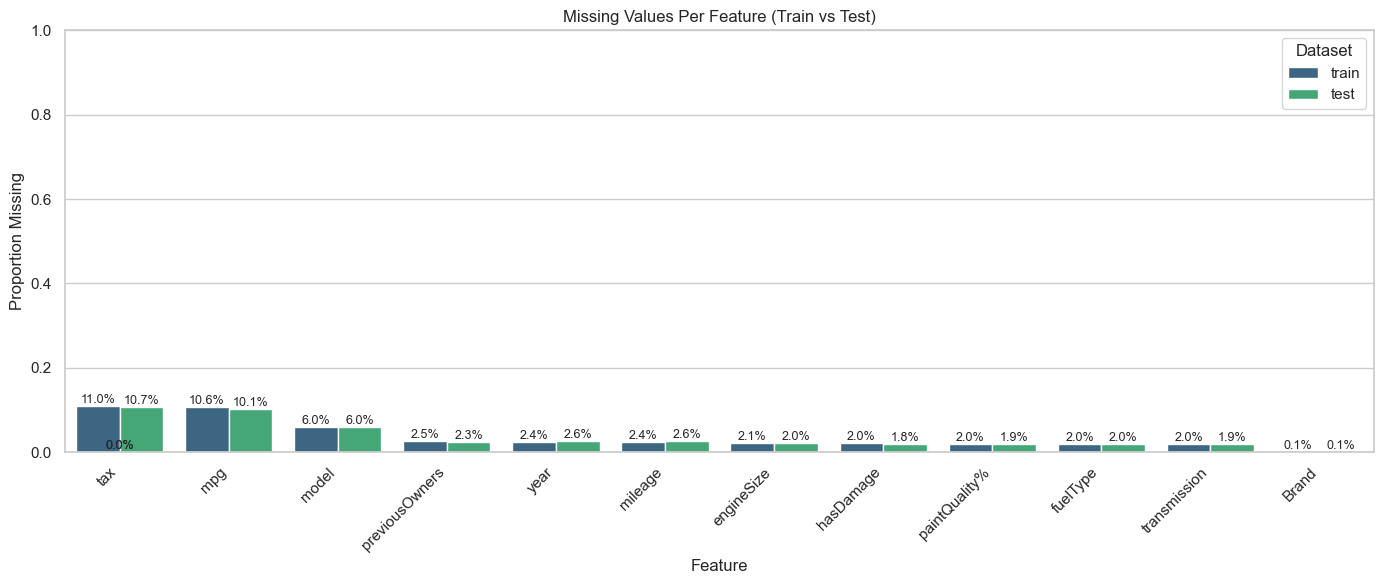

In [494]:
# Columns to exclude
exclude_cols = ["train", "price"]

# Filter columns
train_filtered = train_no_outliers.drop(columns=exclude_cols, errors="ignore")
test_filtered  = test_no_outliers.drop(columns=exclude_cols, errors="ignore")

# Missing proportions
train_missing = train_filtered.isna().mean()
test_missing  = test_filtered.isna().mean()

missing_df = pd.DataFrame({
    "train": train_missing,
    "test": test_missing
})

# Sort by train missing %
missing_df = missing_df.sort_values("train", ascending=False)

# Melt for seaborn
missing_melted = missing_df.reset_index().melt(
    id_vars="index",
    value_vars=["train", "test"],
    var_name="dataset",
    value_name="missing_prop"
)

missing_melted.rename(columns={"index": "feature"}, inplace=True)

# Plot
plt.figure(figsize=(14,6))
ax = sns.barplot(
    data=missing_melted,
    x="feature",
    y="missing_prop",
    hue="dataset",
    palette="viridis"
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Proportion Missing")
plt.xlabel("Feature")
plt.title("Missing Values Per Feature (Train vs Test)")
plt.ylim(0, 1)

# Annotate bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height*100:.1f}%",
        (p.get_x() + p.get_width()/2., height),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.legend(title="Dataset", loc="upper right")
plt.tight_layout()
plt.show()


``tax`` and ``mileage`` account for the largest share of missing values in the dataset, with approximately 11% and 10.5% of observations missing, respectively. They are followed by ``model`` with around 6%, while the remaining features have roughly 2% missingness.

Before choosing an imputation strategy, it is important to distinguish between categorical and numerical variables, as they require different approaches. We must also first determine the type of missingness (MCAR, MAR, or MNAR) present in the dataset, which will determine which imputation methods are appropriate and whether more advanced techniques are justified.

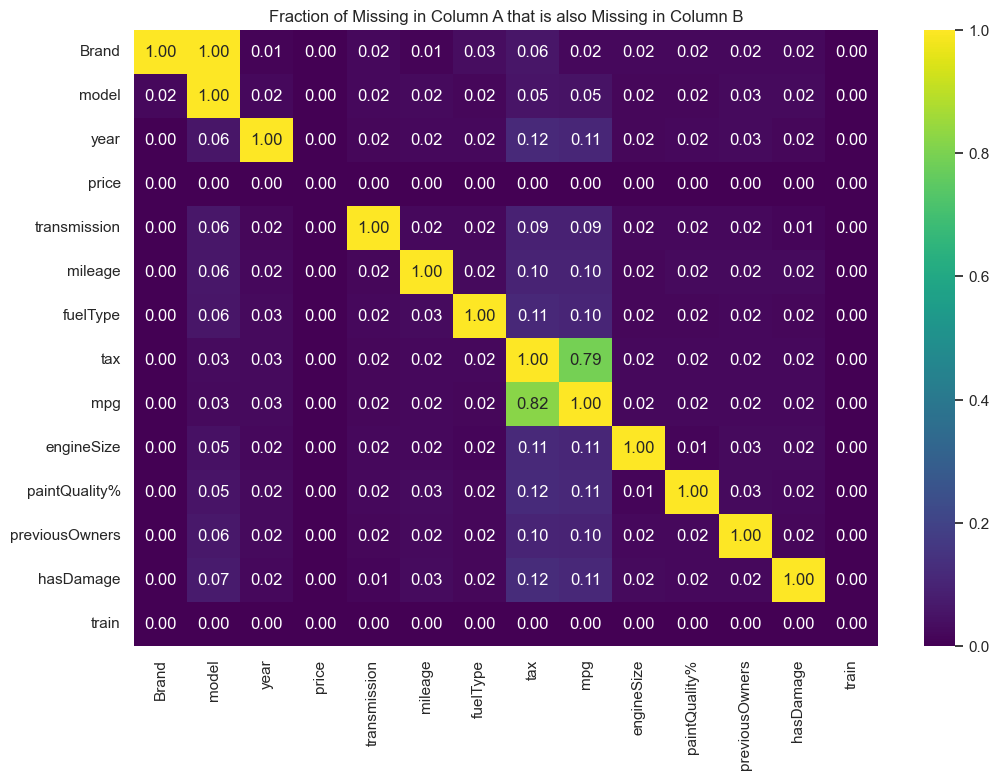

In [495]:
# Boolean DataFrame: True if value is missing
missing_bool = train_no_outliers.isna()

# Conditional co-missing matrix
conditional_missing_matrix = pd.DataFrame(
    index=missing_bool.columns,
    columns=missing_bool.columns,
    dtype=float
)

for col1 in missing_bool.columns:
    for col2 in missing_bool.columns:
        if missing_bool[col1].sum() == 0:
            conditional_missing_matrix.loc[col1, col2] = 0
        else:
            conditional_missing_matrix.loc[col1, col2] = (missing_bool[col1] & missing_bool[col2]).sum() / missing_bool[col1].sum()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conditional_missing_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Fraction of Missing in Column A that is also Missing in Column B")
plt.show()


**Missingness analysis** <br>
This matrix describes the missingness behaviour between different features. It measures how likely it is for feature **B** to be missing given that feature **A** is missing, and vice-versa.

For each pair of variables (A, B), the matrix entry is defined as:

**P(B missing | A missing)**  
= (# rows where A and B are both missing) / (# rows where A is missing)

Because this is a conditional probability, the matrix is **not symmetric**:

**P(B | A) ≠ P(A | B)**

This means the value in position (A, B) generally differs from the value in position (B, A). These two values are generally not equal, because the denominator changes:

Upper diagonal P(A|B):
"Given that A is missing, how often is B missing?"

Lower diagonal P(B\A):
"Given that B is missing, how often is A missing?"`Key takeaway from this analysis is that tax and mpg are missing together

**RESULTS:** <br>
Consider the relationship between ``Brand`` and ``model``. In the upper diagonal (Brand → model), the value is 1.0, indicating that whenever ``Brand`` is missing, model is also missing. In contrast, the lower diagonal (model → Brand) shows a value of 0.02, meaning that when ``model`` is missing, ``Brand`` is almost always present. The fact the dataset contains no records where ``Brand`` is missing while model is present reflects the data cleaning approach, where missing ``Brand`` values were filled using reliable information.

The key takeaway from this analysis is that ``tax`` and ```mpg``` are often missing together and might not be missing at random (MNAR). For the remaining variables, the analysis does not reveal strong relationships, suggesting that most of them are likely missing at random (MAR).

#### **Actionables:** <br>

**Categorical Variables**

Features: ``fuelType``, ``year``, ``previousOwners``, ``transmission``
Strategy: Impute missing values using the mode (most frequent value), as the number of missing entries is low.

``Brand`` missing values will be eliminated. Due to vaery low number of missing values it is con
``Model`` still needs addtional analysis for a decision.

**Numerical Variables (MAR)** <br>
Features: ``mileage``, ``paintQuality%``, ``engineSize``
Strategy: Use KNN Imputer to fill missing values. 


More analaysis in needed: <br>
Features: ``tax``, ``mpg``

Strategy: Investigate further before imputing, since these two variables are often missing together and may not be MAR. Decisions should be based on additional insights and/or business knowledge.

One hypothesis would be that the missing values could be related to electric or alternative-fuel vehicles, which might not have a conventional MPG value and could have special tax treatments.

### Investigating ``tax``, ``mpg`` missing values

Comparing the overall training distributions and descriptive statistics of observations where ``tax`` and ``mpg`` are missing. The goal of this analysis is to find any patterns that may hepl in imputing missing values. 

In [496]:
missing_tax_mpg_df = train_no_outliers[train_no_outliers["tax"].isna() & train_no_outliers["mpg"].isna()]

In [497]:
missing_tax_mpg_df.describe().T

count          mean           std          min      25%  \
year            6375.0   2017.175529      2.222435  2002.000000   2016.0   
price           6534.0  17823.594582   8415.545695   675.000000  11990.0   
mileage         6402.0  22964.527328  21786.635939     1.000000   8000.0   
tax                0.0           NaN           NaN          NaN      NaN   
mpg                0.0           NaN           NaN          NaN      NaN   
engineSize      6392.0      1.647841      0.558953     0.300000      1.0   
paintQuality%   6393.0     64.520763     20.901830     3.207418     47.0   
previousOwners  6395.0      2.015794      1.436238     0.000000      1.0   
hasDamage       6397.0      0.000000      0.000000     0.000000      0.0   

                    50%       75%            max  
year             2018.0   2019.00    2020.000000  
price           16498.0  21736.25   88995.000000  
mileage         15340.5  31261.00  170000.000000  
tax                 NaN       NaN            NaN  
mpg                 NaN       NaN            NaN  
engineSize          1.6      2.00       6.200000  
paintQuality%      64.0     82.00     125.202033  
previousOwners      2.0      3.00       6.000000  
hasDamage           0.0      0.00       0.000000

In [498]:
train_no_outliers.describe().T

count          mean           std          min      25%  \
year            73199.0   2017.091600      2.106715  1970.000000   2016.0   
price           75029.0  16829.221035   9650.320554   450.000000  10200.0   
mileage         73220.0  23151.337820  21198.820702     1.000000   7526.5   
tax             66761.0    119.242655     59.910791     0.000000    125.0   
mpg             67101.0     54.830865     12.600405     1.100000     47.1   
engineSize      73447.0      1.657575      0.550004     0.200000      1.2   
paintQuality%   73525.0     64.592653     21.032033     1.638913     47.0   
previousOwners  73129.0      2.014303      1.440934     0.000000      1.0   
hasDamage       73501.0      0.000000      0.000000     0.000000      0.0   

                    50%       75%            max  
year             2017.0   2019.00    2020.000000  
price           14650.0  20847.00  159999.000000  
mileage         17308.0  32345.25  170000.000000  
tax               145.0    145.00     300.000000  
mpg                54.3     62.80     148.700000  
engineSize          1.6      2.00       6.600000  
paintQuality%      65.0     82.00     125.594308  
previousOwners      2.0      3.00       6.000000  
hasDamage           0.0      0.00       0.000000

In [499]:
train_no_outliers.describe(include="object").T

count unique     top   freq
Brand         74940      9    Ford  16316
model         70505    132   Focus   6895
transmission  73535      5  Manual  41366
fuelType      73532      5  Petrol  40740

In [500]:
missing_tax_mpg_df.describe(include="object").T

count unique     top  freq
Brand         6533      9    Ford  3781
model         6402     22   Focus  3698
transmission  6424      4  Manual  3287
fuelType      6406      4  Petrol  3424

The initial hypothesis that missing ``tax`` and ``mpg`` values might be linked to eletrical vehicles does not hold. Upon inspection, most rows where both variables are missing correspond to Petrol cars, not electric ones. 

A significant proportion of these missing values are Ford Focus model, which is expected as it is the most represented model with 10% of the total observations in the dataset. However, for rows where both tax and mpg are missing, the proportion rises to over 50%, indicating a overrepresentation.

On a another note electric vehicles are extremely rare in the dataset, with only two observations in the training set and one observation in the test set. This should be a reason for concern as the model will not generalize well for electric cars, the main reason being insufficient data to learn patterns specific to these vehicles.

In [501]:
# Compute model counts for both datasets
train_counts = train_no_outliers["model"].value_counts()
test_count = test_no_outliers["model"].value_counts()
missing_counts = missing_tax_mpg_df["model"].value_counts()

# Combine into a dataframe
model_df = pd.DataFrame({
    "train_count": train_counts,
    "test_count": test_count,
    "missing_count": missing_counts
}).fillna(0)

# Convert counts to proportions
model_df["train_prop"] = model_df["train_count"] / model_df["train_count"].sum()
model_df["test_prop"] = model_df["test_count"] / model_df["test_count"].sum()
model_df["missing_prop"] = model_df["missing_count"] / model_df["missing_count"].sum()

In [502]:
model_df[["train_prop", "test_prop", "missing_prop"]].sort_values(["train_prop", "missing_prop"], ascending=False)

train_prop  test_prop  missing_prop
model                                       
Focus      0.097794   0.095462      0.577632
C-Class    0.079072   0.077428      0.417838
Fiesta     0.063258   0.064164      0.000625
Golf       0.044380   0.045085      0.000469
Corsa      0.033416   0.033454      0.000156
...             ...        ...           ...
Fox        0.000014   0.000098      0.000000
RS         0.000014   0.000000      0.000000
S5         0.000000   0.000065      0.000000
SL         0.000000   0.000033      0.000000
i3         0.000000   0.000555      0.000000

[135 rows x 3 columns]

The **Ford Focus** and **Mercedes C-Class** account for a disproportionate share of missing values:

- Focus represents ~9.8% of the full training set but ~57.9% of the missing subset.
- C-Class rises from ~7.9% in the training set to ~41.6% in the missing set.

Based on the available evidence, the missing values in ``tax`` and ``mpg`` do not appear to be **Missing Completely at Random (MCAR)**, since it is clearly associated with an observed variable: the car model.

Because the missingness is linked to an observed variable, the mechanism is at least **MAR**. This is the most convinient scenario for analysis, as it allows us to condition imputation on the car model (e.g., impute Focus's missing MPG using the average MPG of other Focuses).

However, given that ``tax`` and ``mpg`` are important economic indicators in car sales, it is also plausible the missingness mechanism is **MNAR**. Under MNAR, the probability of a value being missing depends on the unobserved value itself—for example, cars with unusually high tax values may be more likely to have that information omitted.

In summary:

- The observed pattern shows that missingness is related to the car model, an observed variable.
- This indicates a systematic form of missingness consistent with MAR.
- With the current information, we cannot determine whether the missingness also depends on the unobserved values themselves, which would indicate MNAR.

Therefore, as of right now the most appropriate classification is: **MAR**

#### **Actionables:** <br>
Dataset will be split into Focus and C-Class and rest of models. The rest of models will be imputed using mean or mode depending on data distributions. The Focus and C-class models will be imputed using KnnImputer fitted on the C-class and Focus models separatly.

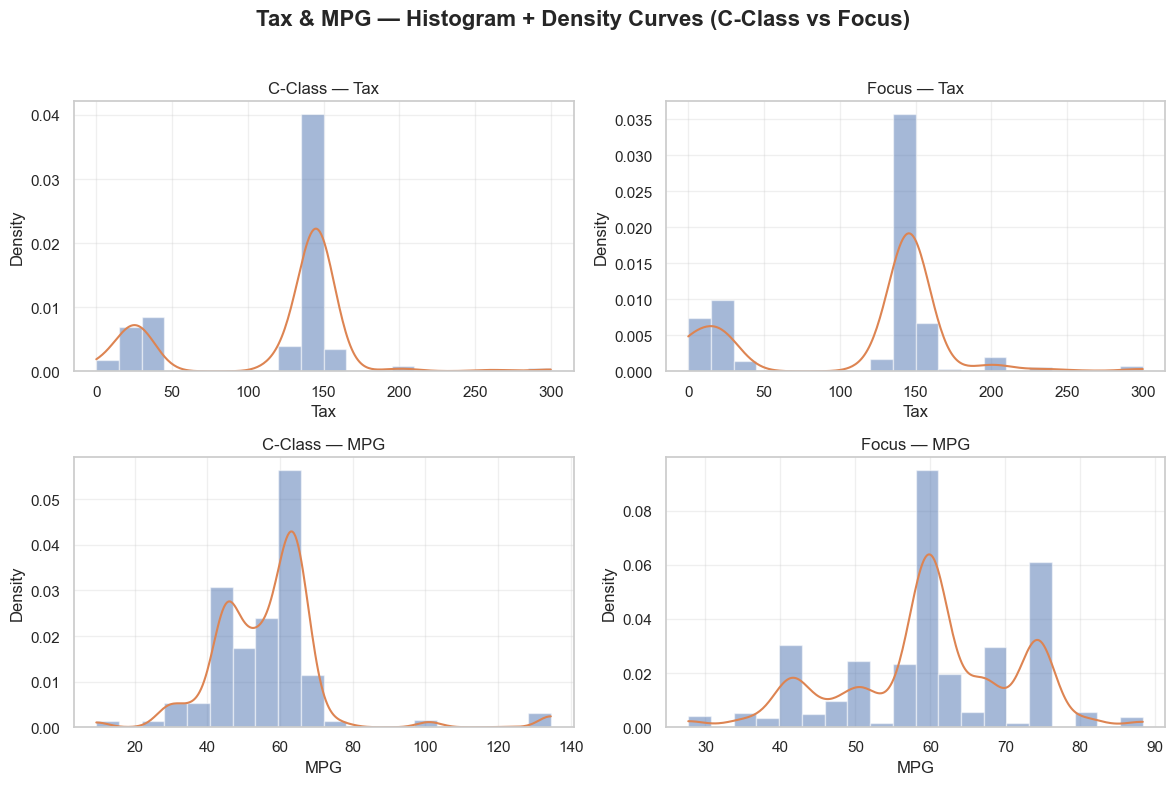

In [503]:
# Filter the models
cclass = train_no_outliers[train_no_outliers["model"] == "C-Class"]
focus  = train_no_outliers[train_no_outliers["model"] == "Focus"]

# Helper: plot histogram + density curve
def plot_hist_kde(ax, data, title, xlabel):
    data = data.dropna()

    # Histogram (density)
    ax.hist(data, bins=20, density=True, alpha=0.5)

    # Density curve
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 300)
    ax.plot(x_vals, kde(x_vals))

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Density")
    ax.grid(alpha=0.3)


# Create 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Tax & MPG — Histogram + Density Curves (C-Class vs Focus)", 
             fontsize=16, fontweight="bold")

plot_hist_kde(axes[0, 0], cclass["tax"],  "C-Class — Tax", "Tax")
plot_hist_kde(axes[0, 1], focus["tax"],   "Focus — Tax",    "Tax")
plot_hist_kde(axes[1, 0], cclass["mpg"],  "C-Class — MPG",  "MPG")
plot_hist_kde(axes[1, 1], focus["mpg"],   "Focus — MPG",    "MPG")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

While the tax distributions show only minor differences across models, the mpg distributions vary considerably, suggesting stronger model-specific patterns in fuel efficiency.

C:\Users\henri\AppData\Local\Temp\ipykernel_22124\3511774010.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_outliers['engineSize_bin'] = pd.cut(train_no_outliers['engineSize'], bins=bins, labels=labels)
C:\Users\henri\AppData\Local\Temp\ipykernel_22124\3511774010.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='engineSize_bin', y='mpg', data=train_no_outliers, ax=axes[0], palette='coolwarm')
C:\Users\henri\AppData\Local\Temp\ipykernel_22124\3511774010.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` v

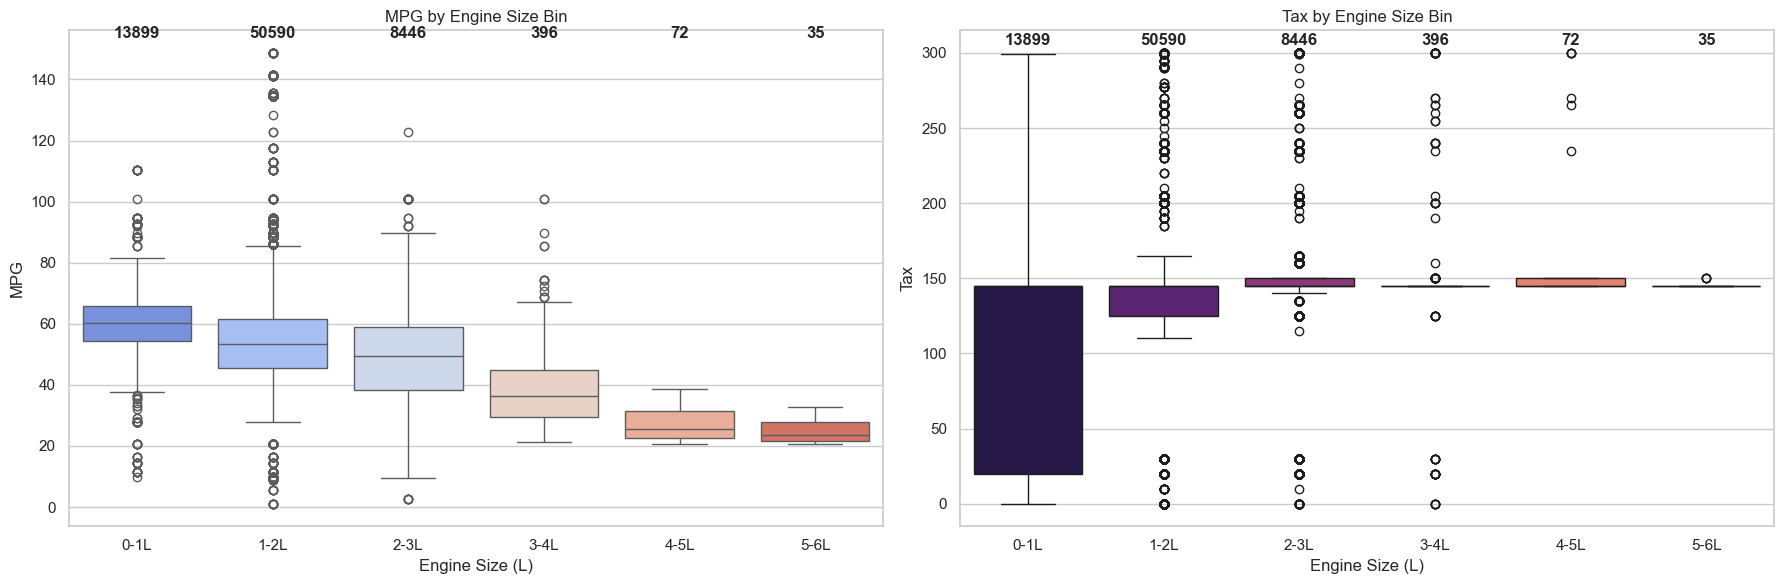

In [504]:
# Create bins for engineSize
bins = [0, 1, 2, 3, 4, 5, 6]
labels = ['0-1L', '1-2L', '2-3L', '3-4L', '4-5L', '5-6L']
train_no_outliers['engineSize_bin'] = pd.cut(train_no_outliers['engineSize'], bins=bins, labels=labels)

# Count number of observations per bin
bin_counts = train_no_outliers['engineSize_bin'].value_counts().sort_index()

# Set up figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot for MPG vs Engine Size bins
sns.boxplot(x='engineSize_bin', y='mpg', data=train_no_outliers, ax=axes[0], palette='coolwarm')
axes[0].set_title('MPG by Engine Size Bin')
axes[0].set_xlabel('Engine Size (L)')
axes[0].set_ylabel('MPG')

# Annotate counts on top of each box
for i, count in enumerate(bin_counts):
    axes[0].text(i, train_no_outliers['mpg'].max() + 5, str(count), ha='center', fontweight='bold')

# Boxplot for Tax vs Engine Size bins
sns.boxplot(x='engineSize_bin', y='tax', data=train_no_outliers, ax=axes[1], palette='magma')
axes[1].set_title('Tax by Engine Size Bin')
axes[1].set_xlabel('Engine Size (L)')
axes[1].set_ylabel('Tax')

# Annotate counts on top of each box
for i, count in enumerate(bin_counts):
    axes[1].text(i, train_no_outliers['tax'].max() + 5, str(count), ha='center', fontweight='bold')

train_no_outliers = train_no_outliers.drop(['engineSize_bin'], axis=1)
plt.tight_layout()
plt.show()

In general, smaller car models tend to have better fuel efficiency— the smaller the engine, the higher the mpg. Likewise, smaller engines are typically associated with lower tax values.

C:\Users\henri\AppData\Local\Temp\ipykernel_22124\424718572.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fuelType', y='mpg', data=train_no_outliers, ax=axes[0], palette='Set2')
C:\Users\henri\AppData\Local\Temp\ipykernel_22124\424718572.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fuelType', y='tax', data=train_no_outliers, ax=axes[1], palette='Set3')


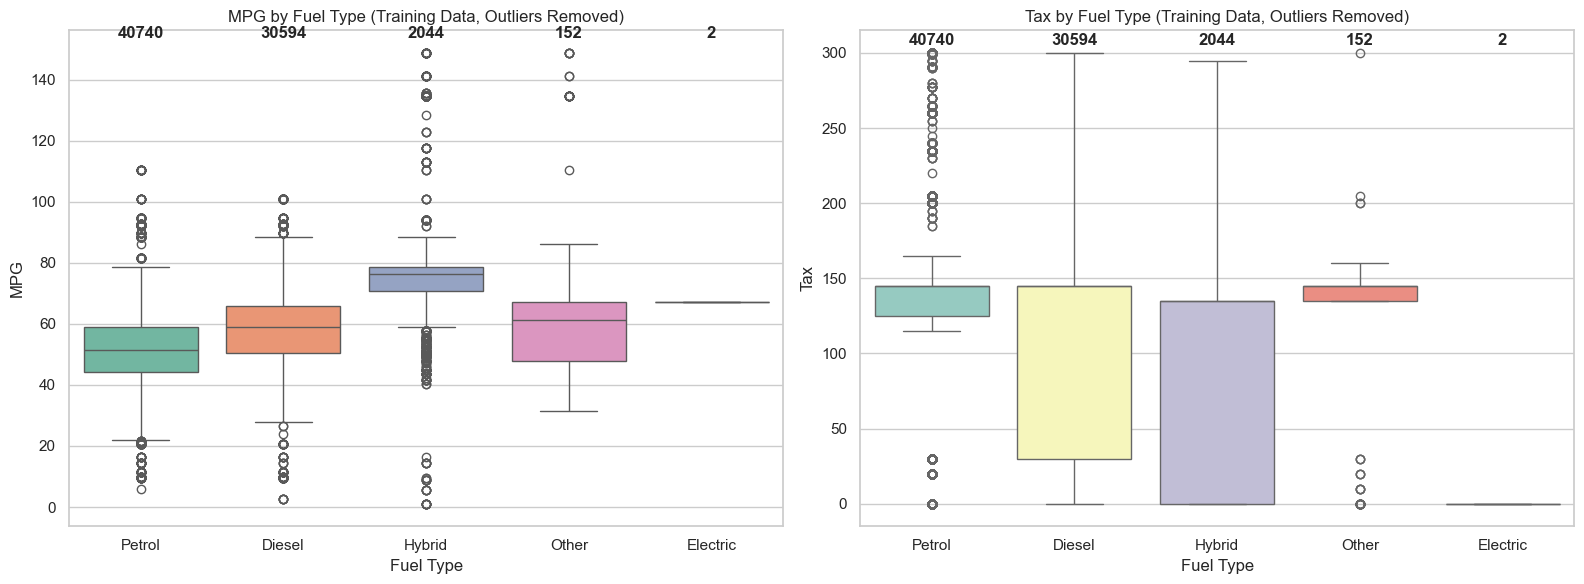

In [505]:
# Count number of observations per fuelType in train_no_outliers
fuel_counts = train_no_outliers['fuelType'].value_counts()

# Set up figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for MPG vs Fuel Type
sns.boxplot(x='fuelType', y='mpg', data=train_no_outliers, ax=axes[0], palette='Set2')
axes[0].set_title('MPG by Fuel Type (Training Data, Outliers Removed)')
axes[0].set_xlabel('Fuel Type')
axes[0].set_ylabel('MPG')

# Annotate counts on top of each box
for i, fuel in enumerate(fuel_counts.index):
    axes[0].text(i, train_no_outliers['mpg'].max() + 5, str(fuel_counts[fuel]), ha='center', fontweight='bold')

# Boxplot for Tax vs Fuel Type
sns.boxplot(x='fuelType', y='tax', data=train_no_outliers, ax=axes[1], palette='Set3')
axes[1].set_title('Tax by Fuel Type (Training Data, Outliers Removed)')
axes[1].set_xlabel('Fuel Type')
axes[1].set_ylabel('Tax')

# Annotate counts on top of each box
for i, fuel in enumerate(fuel_counts.index):
    axes[1].text(i, train_no_outliers['tax'].max() + 5, str(fuel_counts[fuel]), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


Hybrid cars show the best fuel efficiency, followed by diesel vehicles, with petrol and other fuel types performing less efficiently. This is consistent with the earlier analysis: higher mpg values tend to be associated with lower tax rates. Overall, hybrid cars pay the least tax, followed by diesel, petrol, and finally other fuel types.

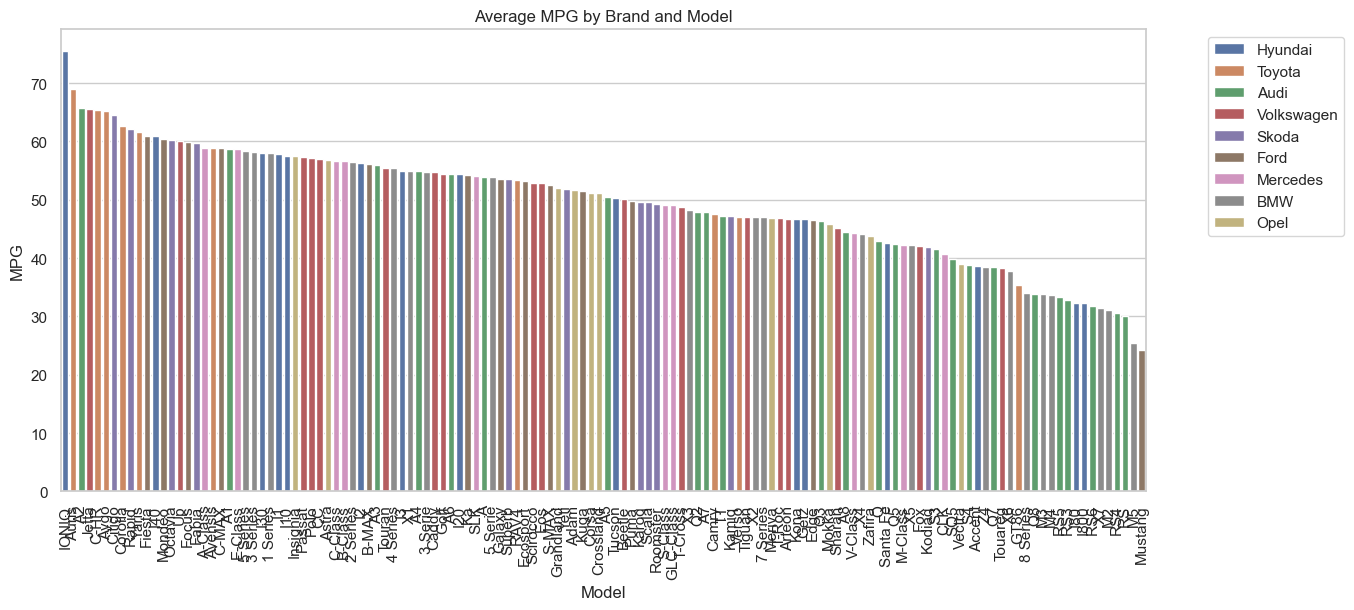

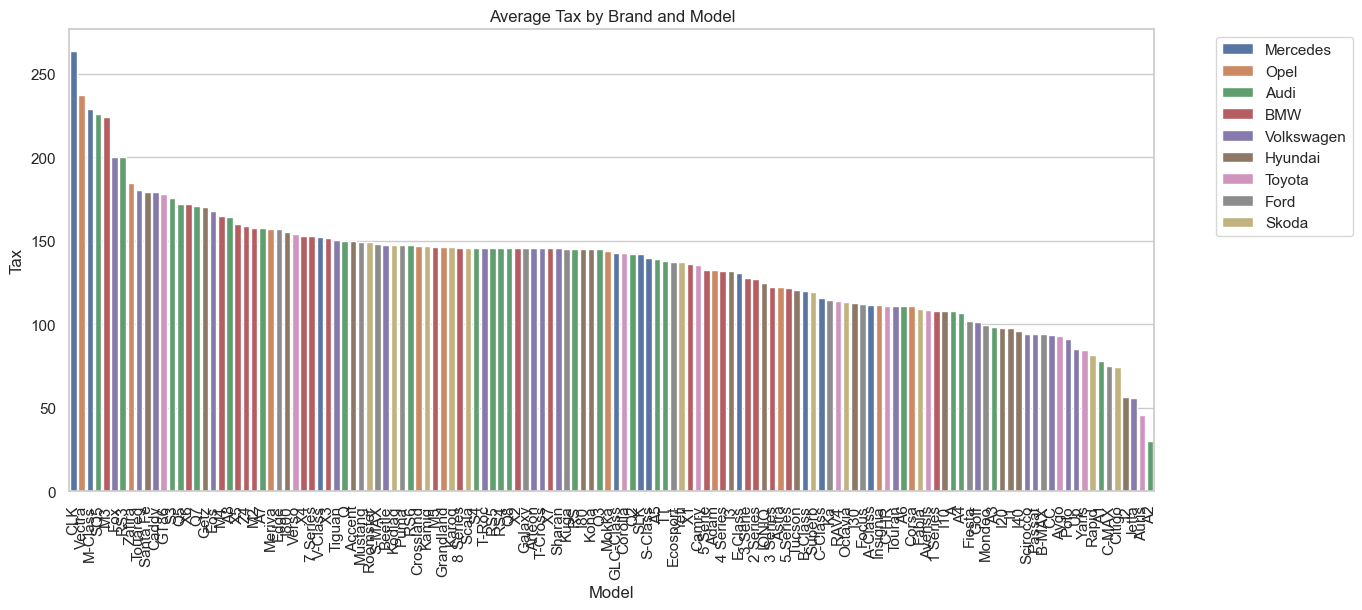

In [506]:
grouped_df = train_no_outliers.groupby(["Brand", "model"])[["mpg", "tax"]].mean().reset_index()

# Plot MPG
plt.figure(figsize=(14,6))
sns.barplot(
    data=grouped_df.sort_values("mpg", ascending=False),
    x="model", y="mpg", hue="Brand"
)
plt.xticks(rotation=90)
plt.title("Average MPG by Brand and Model")
plt.ylabel("MPG")
plt.xlabel("Model")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# Plot Tax
plt.figure(figsize=(14,6))
sns.barplot(
    data=grouped_df.sort_values("tax", ascending=False),
    x="model", y="tax", hue="Brand"
)
plt.xticks(rotation=90)
plt.title("Average Tax by Brand and Model")
plt.ylabel("Tax")
plt.xlabel("Model")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

As expected, tax and MPG values exhibit clear, model-specific patterns, resulting in consistent and distinct calues of ``tax`` ``mpg`` across different car models.

### Investigating model missing values

In [507]:
# Total number of cars per brand
brand_counts = df_no_outliers['Brand'].value_counts()

# Number of missing model values per brand
brand_missing_model = df_no_outliers[df_no_outliers['model'].isna()]['Brand'].value_counts()

# Combine into a DataFrame
missing_model_df = pd.DataFrame({
    'total': brand_counts,
    'missing_model': brand_missing_model
}).fillna(0)

missing_model_df['missing_prop'] = missing_model_df['missing_model'] / missing_model_df['total']

missing_model_df.sort_values('missing_prop', ascending=False)

total  missing_model  missing_prop
Brand                                         
Skoda        6235            564      0.090457
Hyundai      4812            413      0.085827
Toyota       6683            561      0.083944
Opel        13576           1086      0.079994
Volkswagen  14683           1121      0.076347
BMW         10863            680      0.062598
Mercedes    16771            758      0.045197
Ford        23338            934      0.040021
Audi        10511            241      0.022928

In [508]:
df_no_outliers["model"] = df_no_outliers["model"].fillna("Unknown")
filled_df["model"] = filled_df["model"].fillna("Unknown")

Missing values in the model column will belong to category "Unknown".

### Imputing Missing Values

Based on business knowledge and the analysis conducted above, imputation will be carried out at the car-model level to preserve model-specific characteristics. Additionally, C-Class and Focus models will receive targeted treatment for the ``tax`` and ``mpg`` variables due to their distinct missingness patterns.

All imputation metrics will be computed only on the training set and then applied to the test set. Similarly, for methods such as KNNImputer, the imputer will be fitted on the training data and subsequently used to transform the test data. This ensures a correct evaluation procedure and prevents data leakage.

In [509]:
df_imputed = df_no_outliers.copy()

df_focus_cclass = df_imputed[df_imputed["model"].isin(["C-Class", "Focus"])]
df_no_focus_cclass = df_imputed[~df_imputed.index.isin(df_focus_cclass.index)]

df_imputed.shape, df_no_focus_cclass.shape, df_focus_cclass.shape

((107596, 14), (89834, 14), (17762, 14))

#### Mean/Mode Imputer

In [510]:
train_no_focus_cclass= df_no_focus_cclass[df_no_focus_cclass["train"] == True]

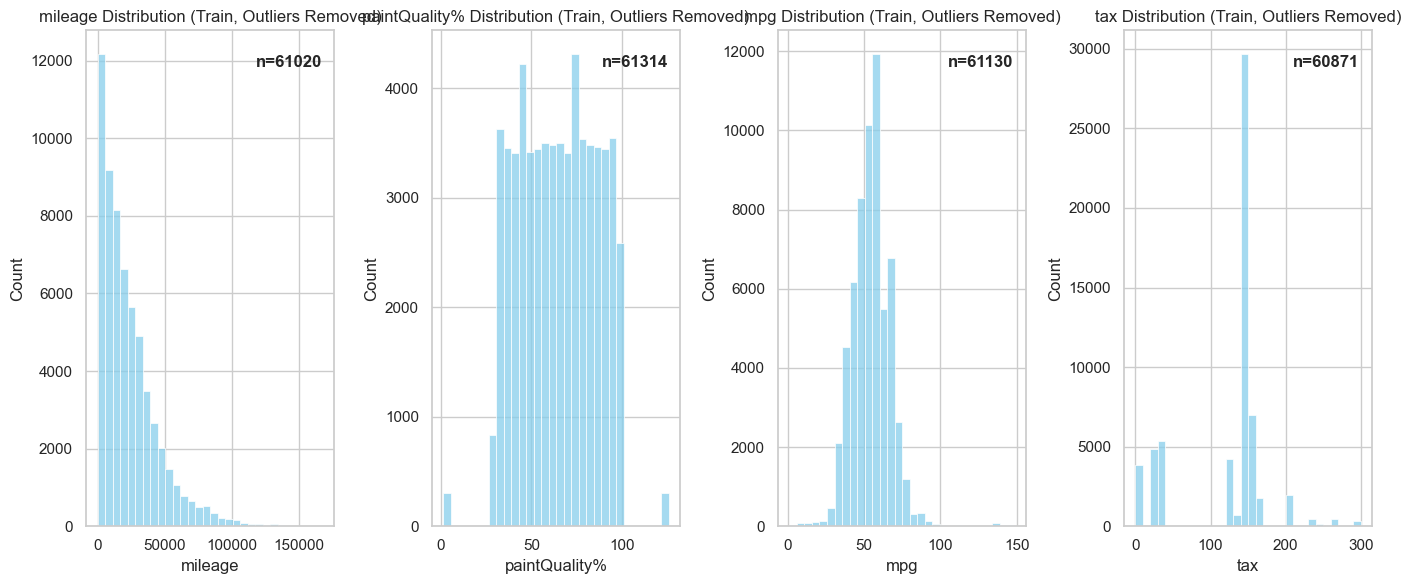

In [511]:
# Columns to plot
cols_to_plot = ["mileage", "paintQuality%", "mpg", "tax"]

# Set up figure
fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(14, 6))

for i, col in enumerate(cols_to_plot):
    sns.histplot(train_no_focus_cclass[col], bins=30, kde=False, ax=axes[i], color="skyblue")
    axes[i].set_title(f"{col} Distribution (Train, Outliers Removed)")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    
    # Annotate total observations
    total = train_no_focus_cclass[col].notna().sum()
    axes[i].text(
        0.95, 0.95,  # position in axes fraction coordinates
        f"n={total}",
        ha="right",
        va="top",
        transform=axes[i].transAxes,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

``Mileage`` shows a strongly right-skewed distribution with a long tail, meaning the median is the most appropriate imputation method. ``Paint quality`` follows a roughly uniform distribution, with similar probabilities across its range; therefore, simple imputation (e.g., mean or median) is acceptable. The mpg variable resembles a more normal-like distribution, making mean imputation reasonable.

In contrast, tax has a highly irregular distribution with large variation. It appears to reflect two distinct behaviours: a sparsely populated range between 0–50, and a much denser concentration between 100–150. This bimodal structure suggests that simple mean or median imputation may not be appropriate without accounting for these subgroups (e.g., conditioning on model or fuel type).

In [512]:
mean_imputation_cols = ["mileage"]
median_imputation_cols = ["paintQuality%", "mpg", "tax"]
mode_imputation_cols = ["previousOwners", "transmission", "year", "fuelType", "engineSize"] 

In [513]:
# Option1
medians = train_no_focus_cclass[median_imputation_cols].median()
means = train_no_focus_cclass[mean_imputation_cols].mean()
modes = train_no_focus_cclass[mode_imputation_cols].mode().iloc[0]

#Option 2

# Median for numeric variables (skewed)
medians_by_model = train_no_focus_cclass.groupby('model')[mean_imputation_cols].median()

# Mean for numeric variables (normal)
means_by_model = train_no_focus_cclass.groupby('model')[mean_imputation_cols].mean()

# Mode for categorical variables
modes_by_model = train_no_focus_cclass.groupby('model')[mode_imputation_cols] \
                                      .agg(lambda x: x.mode().iloc[0])

In this step, two imputation options are considered:

- Global metrics: compute overall mean, median, or mode from the training set and use these to impute missing values in both the training and test sets.

- Model-specific metrics: compute mean, median, or mode per car model and use these values for imputation.

Using model-specific averages can be beneficial when there is significant variation across models for the imputed variables, as it preserves model-specific characteristics. However, it may also introduce bias if certain models have a small number of observations in the training set, leading to less representative imputation values.

In our dataset, only about 2% of values are missing for the variables imputed using this method. Therefore, we do not expect major changes in model results. Nevertheless, both imputation strategies will be experimented with during model evaluation to assess their impact.

In [514]:
df_imputed[median_imputation_cols] = df_imputed[median_imputation_cols].fillna(medians)
df_imputed[mean_imputation_cols] = df_imputed[mean_imputation_cols].fillna(means)
df_imputed[mode_imputation_cols] = df_imputed[mode_imputation_cols].fillna(modes)

df_imputed[mode_imputation_cols + mean_imputation_cols + median_imputation_cols].isna().sum()

previousOwners    0
transmission      0
year              0
fuelType          0
engineSize        0
mileage           0
paintQuality%     0
mpg               0
tax               0
dtype: int64

In [515]:
df_imputed

Brand     model    year    price    transmission       mileage  \
carID                                                                         
69512   Volkswagen      Golf  2016.0  22290.0  Semi-Automatic  28421.000000   
53000       Toyota     Yaris  2019.0  13790.0          Manual   4589.000000   
6366          Audi        Q2  2019.0  24990.0  Semi-Automatic   3624.000000   
29021         Ford    Fiesta  2018.0  12500.0          Manual   9102.000000   
10062          BMW  2 Series  2019.0  22995.0          Manual   1000.000000   
...            ...       ...     ...      ...             ...           ...   
105775  Volkswagen    Tiguan  2017.0      NaN          Manual  27575.000000   
81363          BMW        X2  2020.0      NaN       Automatic   1980.000000   
76833         Audi        Q5  2019.0      NaN  Semi-Automatic   8297.000000   
91768     Mercedes   A-Class  2019.0      NaN          Manual  23147.929099   
99627       Toyota     Yaris  2017.0      NaN       Automatic  11071.000000   

       fuelType    tax        mpg  engineSize  paintQuality%  previousOwners  \
carID                                                                          
69512    Petrol  145.0  11.417268         2.0           63.0             4.0   
53000    Petrol  145.0  47.900000         1.5           50.0             1.0   
6366     Petrol  145.0  40.900000         1.5           56.0             4.0   
29021    Petrol  145.0  65.700000         1.0           50.0             0.0   
10062    Petrol  145.0  42.800000         1.5           97.0             3.0   
...         ...    ...        ...         ...            ...             ...   
105775   Petrol  145.0  46.300000         1.4           94.0             1.0   
81363    Petrol  145.0  34.000000         2.0           39.0             3.0   
76833    Diesel  145.0  38.200000         2.0           88.0             4.0   
91768    Petrol  145.0  28.500000         1.3           81.0             1.0   
99627    Petrol   30.0  58.000000         1.3           98.0             4.0   

        hasDamage  train  
carID                     
69512         0.0   True  
53000         0.0   True  
6366          0.0   True  
29021         0.0   True  
10062         0.0   True  
...           ...    ...  
105775        0.0  False  
81363         0.0  False  
76833         0.0  False  
91768         0.0  False  
99627         0.0  False  

[107596 rows x 14 columns]

#### KNNImputer of ``mpg`` and ``tax``

In [516]:
cols_imputer_ohe = ["model", "transmission", "fuelType", "year"]
col_n_impute = ["mileage", "engineSize", "tax", "mpg"]

In [517]:
df_focus_cclass_scaled_impute, impute_scaler = scaleNumVariables(df_focus_cclass, col_n_impute, method="Robust", supervised=True)
df_focus_cclass_scaled_impute

Brand    model    year    price    transmission   mileage fuelType  \
carID                                                                          
23348      Ford    Focus  2019.0  15300.0          Manual -0.218692   Petrol   
20142      Ford    Focus  2017.0  18997.0          Manual  0.181644   Petrol   
39796  Mercedes  C-Class  2019.0  31299.0  Semi-Automatic -0.631278   Diesel   
35317  Mercedes  C-Class  2019.0  26176.0             NaN -0.271307   Petrol   
35263  Mercedes  C-Class     NaN  11295.0       Automatic  1.240246   Petrol   
...         ...      ...     ...      ...             ...       ...      ...   
95091  Mercedes  C-Class  2019.0      NaN  Semi-Automatic -0.072670   Petrol   
84639      Ford    Focus  2017.0      NaN          Manual -0.142768   Petrol   
95742  Mercedes  C-Class  2019.0      NaN  Semi-Automatic -0.424730   Diesel   
91996  Mercedes  C-Class  2016.0      NaN       Automatic  2.282558   Diesel   
92823  Mercedes  C-Class  2019.0      NaN  Semi-Automatic -0.225285   Petrol   

            tax       mpg  engineSize  paintQuality%  previousOwners  \
carID                                                                  
23348  0.043478  0.000000        -0.6           35.0             1.0   
20142       NaN       NaN         0.4           40.0             4.0   
39796       NaN       NaN         0.4           33.0             4.0   
35317       NaN       NaN        -0.1           87.0             1.0   
35263       NaN -0.945205         0.0           59.0             NaN   
...         ...       ...         ...            ...             ...   
95091       NaN       NaN        -0.1           91.0             2.0   
84639  0.043478  0.000000        -0.6            NaN             0.0   
95742  0.000000  0.089041         0.4           38.0             3.0   
91996 -0.173913       NaN         0.5           87.0             1.0   
92823       NaN       NaN        -0.1            NaN             1.0   

       hasDamage  train  
carID                    
23348        0.0   True  
20142        0.0   True  
39796        0.0   True  
35317        0.0   True  
35263        0.0   True  
...          ...    ...  
95091        0.0  False  
84639        0.0  False  
95742        0.0  False  
91996        0.0  False  
92823        0.0  False  

[17762 rows x 14 columns]

In [518]:
df_focus_cclass_scaled_impute = df_focus_cclass_scaled_impute[cols_imputer_ohe + col_n_impute + ["train"]]
df_focus_cclass_scaled_impute

model    transmission fuelType    year   mileage  engineSize  \
carID                                                                   
23348    Focus          Manual   Petrol  2019.0 -0.218692        -0.6   
20142    Focus          Manual   Petrol  2017.0  0.181644         0.4   
39796  C-Class  Semi-Automatic   Diesel  2019.0 -0.631278         0.4   
35317  C-Class             NaN   Petrol  2019.0 -0.271307        -0.1   
35263  C-Class       Automatic   Petrol     NaN  1.240246         0.0   
...        ...             ...      ...     ...       ...         ...   
95091  C-Class  Semi-Automatic   Petrol  2019.0 -0.072670        -0.1   
84639    Focus          Manual   Petrol  2017.0 -0.142768        -0.6   
95742  C-Class  Semi-Automatic   Diesel  2019.0 -0.424730         0.4   
91996  C-Class       Automatic   Diesel  2016.0  2.282558         0.5   
92823  C-Class  Semi-Automatic   Petrol  2019.0 -0.225285        -0.1   

            tax       mpg  train  
carID                             
23348  0.043478  0.000000   True  
20142       NaN       NaN   True  
39796       NaN       NaN   True  
35317       NaN       NaN   True  
35263       NaN -0.945205   True  
...         ...       ...    ...  
95091       NaN       NaN  False  
84639  0.043478  0.000000  False  
95742  0.000000  0.089041  False  
91996 -0.173913       NaN  False  
92823       NaN       NaN  False  

[17762 rows x 9 columns]

In [519]:
df_focus_cclass_scaled_encoded_impute, scaler_catVars = encodeCatVariables(df_focus_cclass_scaled_impute, cols_imputer_ohe)
df_focus_cclass_scaled_encoded_impute

mileage  engineSize       tax       mpg  train  model_Focus  \
carID                                                                 
23348 -0.218692        -0.6  0.043478  0.000000   True          1.0   
20142  0.181644         0.4       NaN       NaN   True          1.0   
39796 -0.631278         0.4       NaN       NaN   True          0.0   
35317 -0.271307        -0.1       NaN       NaN   True          0.0   
35263  1.240246         0.0       NaN -0.945205   True          0.0   
...         ...         ...       ...       ...    ...          ...   
95091 -0.072670        -0.1       NaN       NaN  False          0.0   
84639 -0.142768        -0.6  0.043478  0.000000  False          1.0   
95742 -0.424730         0.4  0.000000  0.089041  False          0.0   
91996  2.282558         0.5 -0.173913       NaN  False          0.0   
92823 -0.225285        -0.1       NaN       NaN  False          0.0   

       transmission_Manual  transmission_Other  transmission_Semi-Automatic  \
carID                                                                         
23348                  1.0                 0.0                          0.0   
20142                  1.0                 0.0                          0.0   
39796                  0.0                 0.0                          1.0   
35317                  0.0                 0.0                          0.0   
35263                  0.0                 0.0                          0.0   
...                    ...                 ...                          ...   
95091                  0.0                 0.0                          1.0   
84639                  1.0                 0.0                          0.0   
95742                  0.0                 0.0                          1.0   
91996                  0.0                 0.0                          0.0   
92823                  0.0                 0.0                          1.0   

       transmission_Unkown  ...  year_2012.0  year_2013.0  year_2014.0  \
carID                       ...                                          
23348                  0.0  ...          0.0          0.0          0.0   
20142                  0.0  ...          0.0          0.0          0.0   
39796                  0.0  ...          0.0          0.0          0.0   
35317                  0.0  ...          0.0          0.0          0.0   
35263                  0.0  ...          0.0          0.0          0.0   
...                    ...  ...          ...          ...          ...   
95091                  0.0  ...          0.0          0.0          0.0   
84639                  0.0  ...          0.0          0.0          0.0   
95742                  0.0  ...          0.0          0.0          0.0   
91996                  0.0  ...          0.0          0.0          0.0   
92823                  0.0  ...          0.0          0.0          0.0   

       year_2015.0  year_2016.0  year_2017.0  year_2018.0  year_2019.0  \
carID                                                                    
23348          0.0          0.0          0.0          0.0          1.0   
20142          0.0          0.0          1.0          0.0          0.0   
39796          0.0          0.0          0.0          0.0          1.0   
35317          0.0          0.0          0.0          0.0          1.0   
35263          0.0          0.0          0.0          0.0          0.0   
...            ...          ...          ...          ...          ...   
95091          0.0          0.0          0.0          0.0          1.0   
84639          0.0          0.0          1.0          0.0          0.0   
95742          0.0          0.0          0.0          0.0          1.0   
91996          0.0          1.0          0.0          0.0          0.0   
92823          0.0          0.0          0.0          0.0          1.0   

       year_2020.0  year_nan  
carID                         
23348          0.0       0.0  
20142          0.0       0.0  
39796 

In [520]:
train_impute = df_focus_cclass_scaled_encoded_impute[df_focus_cclass_scaled_encoded_impute["train"] == True]
test_impute = df_focus_cclass_scaled_encoded_impute[df_focus_cclass_scaled_encoded_impute["train"] == False]

In [521]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputer.fit(train_impute)

imputed_train = pd.DataFrame(imputer.transform(train_impute), columns=train_impute.columns, index=train_impute.index)
imputed_test = pd.DataFrame(imputer.transform(test_impute), columns=test_impute.columns, index=test_impute.index)

In [522]:
df_focus_cclass_imputed = pd.concat([imputed_train, imputed_test], axis=0)
df_focus_cclass_imputed = df_focus_cclass_imputed.sort_index()

df_focus_cclass_imputed[col_n_impute] = impute_scaler.inverse_transform(df_focus_cclass_imputed[col_n_impute])
df_focus_cclass_imputed

mileage  engineSize         tax    mpg  train  model_Focus  \
carID                                                               
15013  21456.0         1.0  175.894701  59.14    1.0          1.0   
15014   5492.0         1.0  145.000000  57.66    1.0          1.0   
15015  10998.0         1.0  145.000000  60.10    1.0          1.0   
15016   7864.0         1.0  145.000000  60.10    1.0          1.0   
15017  89000.0         1.6   30.000000  62.80    1.0          1.0   
...        ...         ...         ...    ...    ...          ...   
95986  39000.0         2.1   30.000000  62.80    0.0          0.0   
95987  60948.0         2.1  150.000000  54.30    0.0          0.0   
95991  29689.0         2.1   30.000000  61.40    0.0          0.0   
95992   1864.0         1.5  145.000000  45.60    0.0          0.0   
95994   9705.0         2.1  145.000000  64.20    0.0          0.0   

       transmission_Manual  transmission_Other  transmission_Semi-Automatic  \
carID                                                                         
15013                  1.0                 0.0                          0.0   
15014                  1.0                 0.0                          0.0   
15015                  1.0                 0.0                          0.0   
15016                  1.0                 0.0                          0.0   
15017                  1.0                 0.0                          0.0   
...                    ...                 ...                          ...   
95986                  0.0                 0.0                          1.0   
95987                  0.0                 0.0                          1.0   
95991                  0.0                 0.0                          0.0   
95992                  0.0                 0.0                          0.0   
95994                  0.0                 0.0                          0.0   

       transmission_Unkown  ...  year_2012.0  year_2013.0  year_2014.0  \
carID                       ...                                          
15013                  0.0  ...          0.0          0.0          0.0   
15014                  0.0  ...          0.0          0.0          0.0   
15015                  0.0  ...          0.0          0.0          0.0   
15016                  0.0  ...          0.0          0.0          0.0   
15017                  0.0  ...          0.0          0.0          0.0   
...                    ...  ...          ...          ...          ...   
95986                  0.0  ...          0.0          0.0          0.0   
95987                  0.0  ...          0.0          1.0          0.0   
95991                  0.0  ...          0.0          0.0          0.0   
95992                  0.0  ...          0.0          0.0          0.0   
95994                  0.0  ...          0.0          0.0          0.0   

       year_2015.0  year_2016.0  year_2017.0  year_2018.0  year_2019.0  \
carID                                                                    
15013          0.0          0.0          0.0          1.0          0.0   
15014          0.0          0.0          0.0          0.0          1.0   
15015          0.0          0.0          0.0          0.0          1.0   
15016          0.0          0.0          0.0          0.0          1.0   
15017          0.0          0.0          0.0          0.0          0.0   
...            ...          ...          ...          ...          ...   
95986          1.0          0.0          0.0          0.0          0.0   
95987          0.0          0.0          0.0          0.0          0.0   
95991          0.0          0.0          1.0          0.0          0.0   
95992          0.0          0.0          0.0          0.0          1.0   
95994          0.0          0.0          0.0          1.0          0.0   

       year_2020.0  year_nan  
carID                         
15013          0.0       0.0  
15014          0.0       0.0  
15015          0.0       0.0  


In [523]:
df_imputed[df_imputed["train"]==True]["model"].unique()

array(['Golf', 'Yaris', 'Q2', 'Fiesta', '2 Series', '3 Series', 'A3',
       'Octavia', 'Passat', 'Focus', 'Insignia', 'A-Class', 'Q3', 'Fabia',
       'Ka', 'GLC-Class', 'I30', 'C-Class', 'Polo', 'E-Class', 'Unknown',
       'Q5', 'Up', 'C-HR', 'Mokka', 'Corsa', 'Astra', 'TT', '5 Series',
       'Aygo', '4 Series', 'SLK', 'T-Roc', 'Ecosport', 'Tucson', 'I20',
       'Rapid', 'A1', 'Auris', 'Sharan', 'Adam', 'X3', 'A8', 'B-MAX',
       'A4', 'Kona', 'I10', 'S-MAX', 'X2', 'Crossland', 'Tiguan', 'A5',
       'Zafira', 'IONIQ', 'A6', 'Mondeo', 'X1', 'Scala', 'S-Class',
       '1 Series', 'Kamiq', 'Kuga', 'Q7', 'Arteon', 'Santa Fe',
       'Grandland', 'I800', 'RAV4', 'Touran', 'Citigo', 'Roomster',
       'Corolla', 'B-Class', 'Q', 'Kodiaq', 'V-Class', 'Superb', 'Getz',
       'Beetle', 'Galaxy', 'M3', 'X4', '3 Serie', 'M4', 'Z4', 'X5',
       'Meriva', 'RS6', 'Verso', 'Touareg', 'C-MAX', 'Puma', 'I40',
       'Karoq', 'I3', 'T-Cross', 'A7', 'A', 'GT86', 'Yeti', 'Edge',
       '5 Serie', 

In [524]:
df_imputed.loc[df_focus_cclass_imputed.index, ["tax", "mpg"]] = df_focus_cclass_imputed[["tax", "mpg"]]
df_imputed

Brand     model    year    price    transmission       mileage  \
carID                                                                         
69512   Volkswagen      Golf  2016.0  22290.0  Semi-Automatic  28421.000000   
53000       Toyota     Yaris  2019.0  13790.0          Manual   4589.000000   
6366          Audi        Q2  2019.0  24990.0  Semi-Automatic   3624.000000   
29021         Ford    Fiesta  2018.0  12500.0          Manual   9102.000000   
10062          BMW  2 Series  2019.0  22995.0          Manual   1000.000000   
...            ...       ...     ...      ...             ...           ...   
105775  Volkswagen    Tiguan  2017.0      NaN          Manual  27575.000000   
81363          BMW        X2  2020.0      NaN       Automatic   1980.000000   
76833         Audi        Q5  2019.0      NaN  Semi-Automatic   8297.000000   
91768     Mercedes   A-Class  2019.0      NaN          Manual  23147.929099   
99627       Toyota     Yaris  2017.0      NaN       Automatic  11071.000000   

       fuelType    tax        mpg  engineSize  paintQuality%  previousOwners  \
carID                                                                          
69512    Petrol  145.0  11.417268         2.0           63.0             4.0   
53000    Petrol  145.0  47.900000         1.5           50.0             1.0   
6366     Petrol  145.0  40.900000         1.5           56.0             4.0   
29021    Petrol  145.0  65.700000         1.0           50.0             0.0   
10062    Petrol  145.0  42.800000         1.5           97.0             3.0   
...         ...    ...        ...         ...            ...             ...   
105775   Petrol  145.0  46.300000         1.4           94.0             1.0   
81363    Petrol  145.0  34.000000         2.0           39.0             3.0   
76833    Diesel  145.0  38.200000         2.0           88.0             4.0   
91768    Petrol  145.0  28.500000         1.3           81.0             1.0   
99627    Petrol   30.0  58.000000         1.3           98.0             4.0   

        hasDamage  train  
carID                     
69512         0.0   True  
53000         0.0   True  
6366          0.0   True  
29021         0.0   True  
10062         0.0   True  
...           ...    ...  
105775        0.0  False  
81363         0.0  False  
76833         0.0  False  
91768         0.0  False  
99627         0.0  False  

[107596 rows x 14 columns]

In [525]:
df_imputed.isna().sum()

Brand               124
model                 0
year                  0
price             32567
transmission          0
mileage               0
fuelType              0
tax                   0
mpg                   0
engineSize            0
paintQuality%         0
previousOwners        0
hasDamage          2125
train                 0
dtype: int64

In [526]:
train_imputed = df_imputed[df_imputed["train"] == True]
test_imputed = df_imputed[df_imputed["train"] == False]

In [527]:
test_imputed

Brand      model    year  price    transmission       mileage  \
carID                                                                        
89856      Hyundai        I30  2019.0    NaN       Automatic  30700.000000   
106581  Volkswagen     Tiguan  2017.0    NaN  Semi-Automatic  23147.929099   
80886          BMW   2 Series  2016.0    NaN       Automatic  36792.000000   
100174        Opel  Grandland  2019.0    NaN          Manual   5533.000000   
81376          BMW   1 Series  2019.0    NaN  Semi-Automatic   9058.000000   
...            ...        ...     ...    ...             ...           ...   
105775  Volkswagen     Tiguan  2017.0    NaN          Manual  27575.000000   
81363          BMW         X2  2020.0    NaN       Automatic   1980.000000   
76833         Audi         Q5  2019.0    NaN  Semi-Automatic   8297.000000   
91768     Mercedes    A-Class  2019.0    NaN          Manual  23147.929099   
99627       Toyota      Yaris  2017.0    NaN       Automatic  11071.000000   

       fuelType    tax   mpg  engineSize  paintQuality%  previousOwners  \
carID                                                                     
89856    Petrol  205.0  41.5         1.6           61.0             3.0   
106581   Petrol  150.0  38.2         2.0           60.0             2.0   
80886    Petrol  125.0  51.4         1.5           94.0             2.0   
100174   Petrol  145.0  44.1         1.2           77.0             1.0   
81376    Diesel  150.0  51.4         2.0           45.0             4.0   
...         ...    ...   ...         ...            ...             ...   
105775   Petrol  145.0  46.3         1.4           94.0             1.0   
81363    Petrol  145.0  34.0         2.0           39.0             3.0   
76833    Diesel  145.0  38.2         2.0           88.0             4.0   
91768    Petrol  145.0  28.5         1.3           81.0             1.0   
99627    Petrol   30.0  58.0         1.3           98.0             4.0   

        hasDamage  train  
carID                     
89856         0.0  False  
106581        0.0  False  
80886         0.0  False  
100174        0.0  False  
81376         0.0  False  
...           ...    ...  
105775        0.0  False  
81363         0.0  False  
76833         0.0  False  
91768         0.0  False  
99627         0.0  False  

[32567 rows x 14 columns]

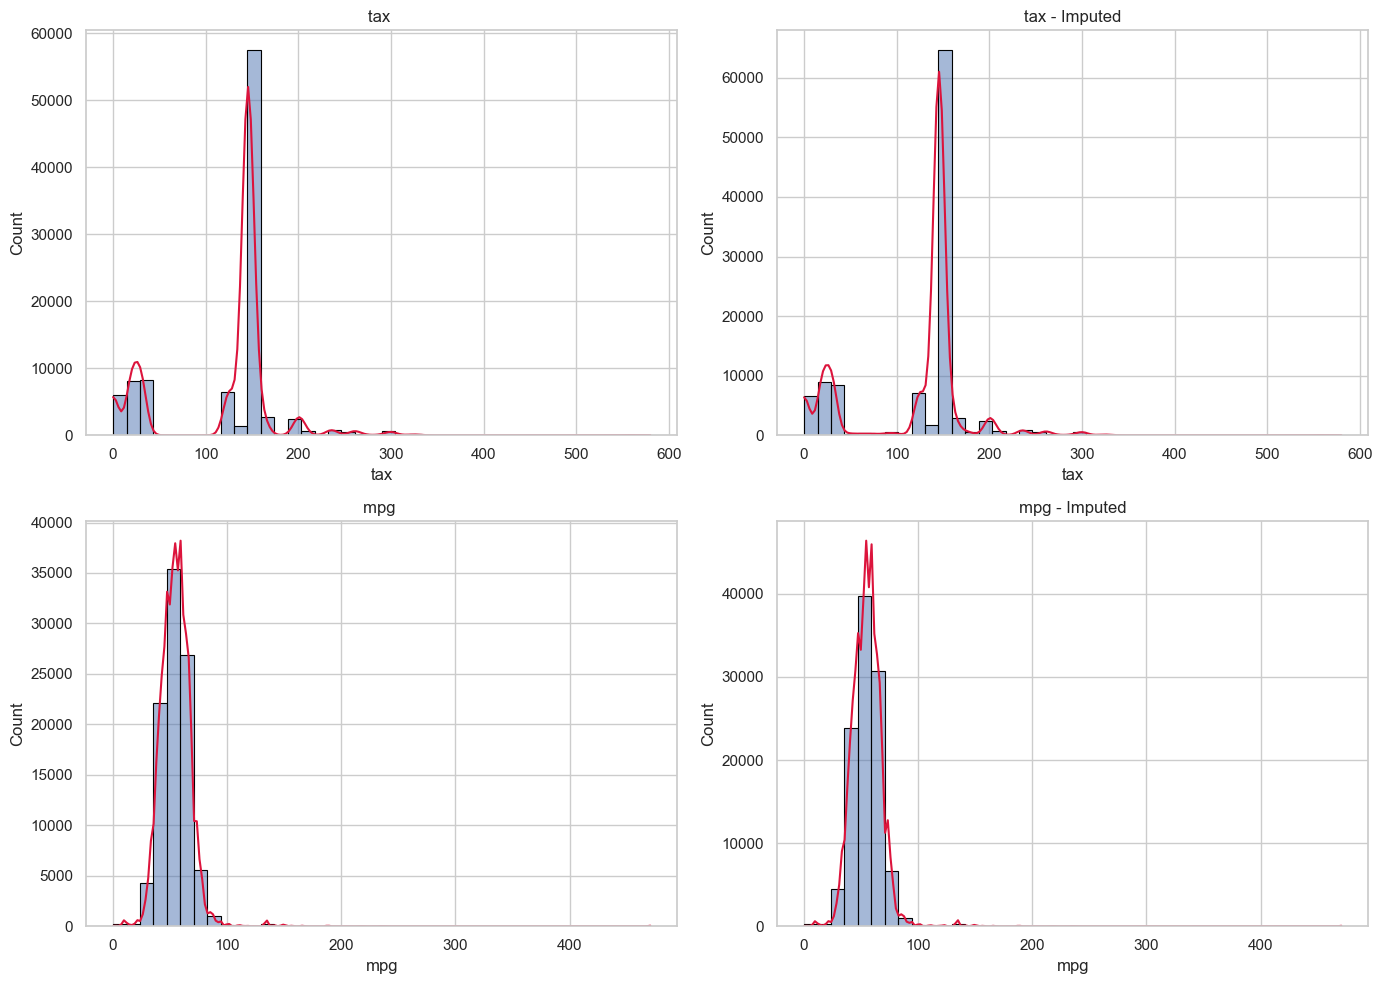

In [528]:
cols_to_compare = ["tax", "mpg"]
# Set up the figure and axes with a smaller figsize
fig, axes = plt.subplots(
    nrows=len(cols_to_compare), 
    ncols=2, 
    figsize=(14, 5*len(cols_to_compare))
)

# Plot histograms and density curves for common numerical columns
for i, col in enumerate(cols_to_compare):
    ax = sns.histplot(df_no_outliers[col], 
                      bins=40, 
                      edgecolor='black', 
                      ax=axes[i, 0], 
                      kde=True, 
                      line_kws={'color': 'red'})
    
    ax.lines[0].set_color('crimson')
    axes[i, 0].set_title(f'{col} ')
    
    ax = sns.histplot(df_imputed[col], 
                      bins=40, 
                      edgecolor='black', 
                      ax=axes[i, 1], 
                      kde=True, 
                      line_kws={'color': 'red'})
    
    ax.lines[0].set_color('crimson')
    axes[i, 1].set_title(f'{col} - Imputed')
    

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

It seems that the imputation was successful: the distributions of mpg and tax before and after imputation are very similar, with only minor discrepancies.

## 3.5 Feature Engineering

In this section, additional exploratory data analysis (EDA) will be carried out. The main goal is to better understand the relationships between the predictor variables themselves, as well as their relationships with the target variable.

In the hopes that this may help in creating more informative features.

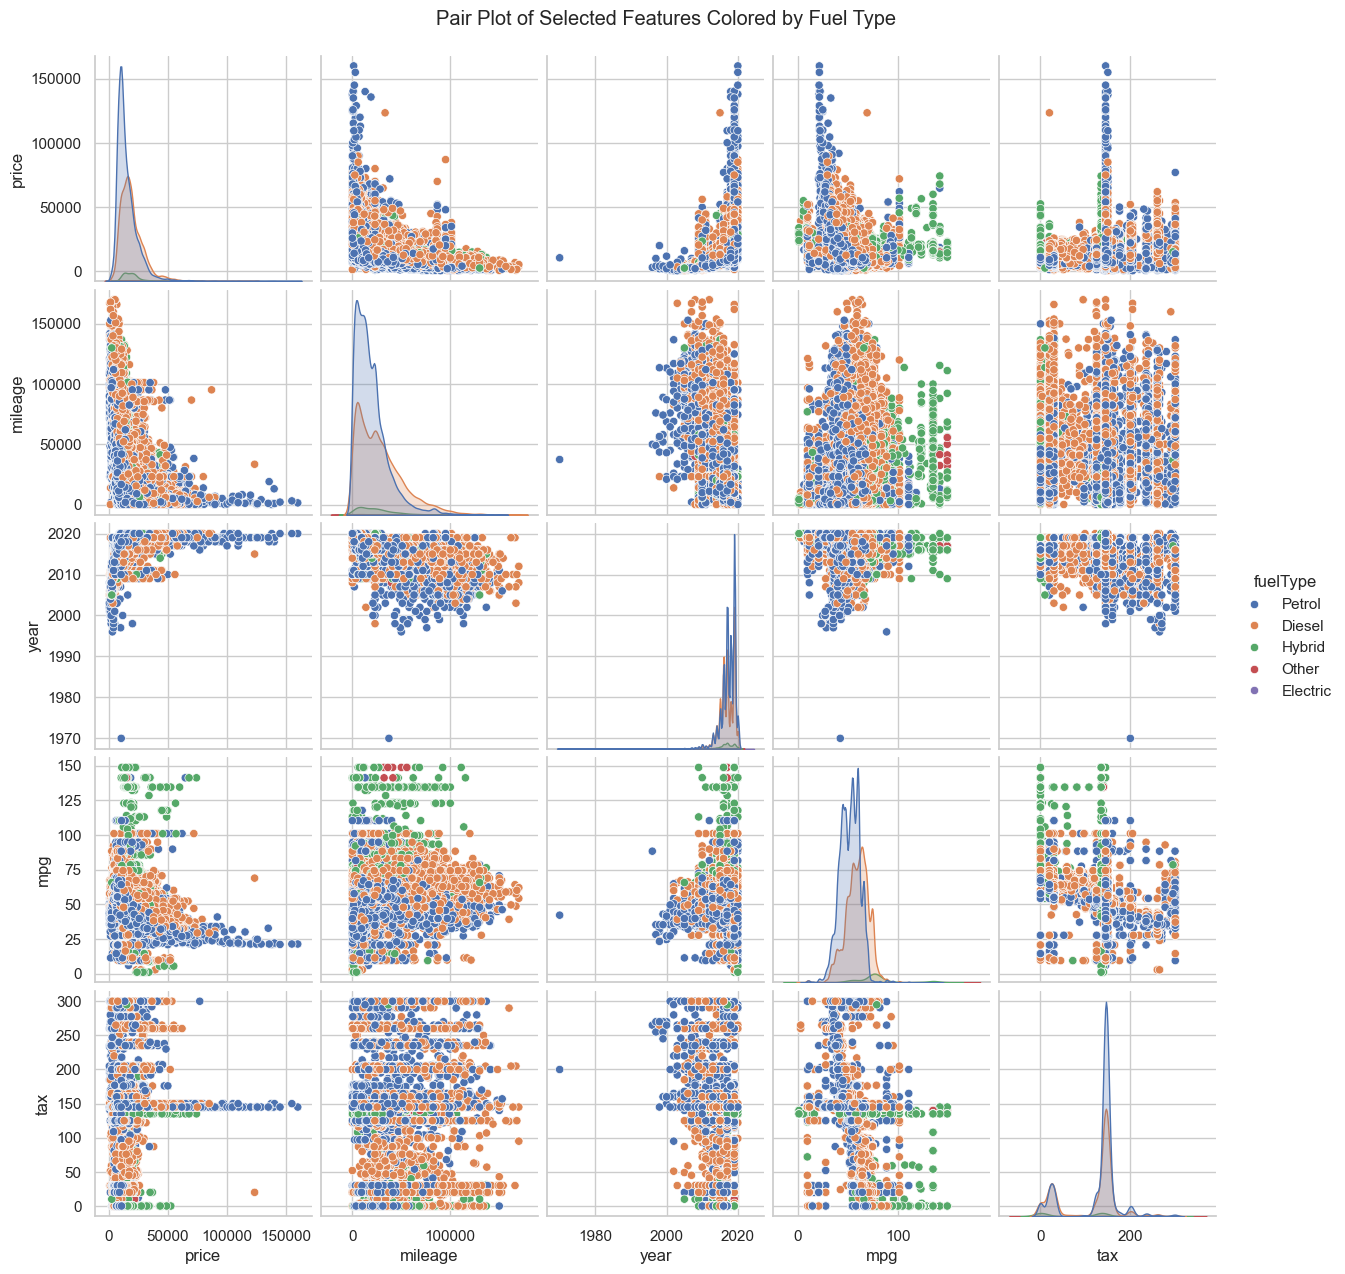

In [529]:
sns.pairplot(train_imputed[['price', 'mileage', 'year', 'mpg', "tax", 'fuelType']], hue='fuelType')
plt.suptitle('Pair Plot of Selected Features Colored by Fuel Type', y=1.02)
plt.show()

Petrol cars appear to be, on average, less expensive than diesel and hybrid cars. Hybrid cars tend to be more efficient, while diesel cars are slightly more efficient than petrol cars, although the difference is not very large. In terms of tax, there seems to be a clear separation in values, suggesting two different distributions: one ranging approximately from 40 to 50, and another from 100 to 300. No clear relationship between tax and fuel type is apparent. Mileage appears to have a negative relationship with price, with higher-mileage cars generally being less expensive.

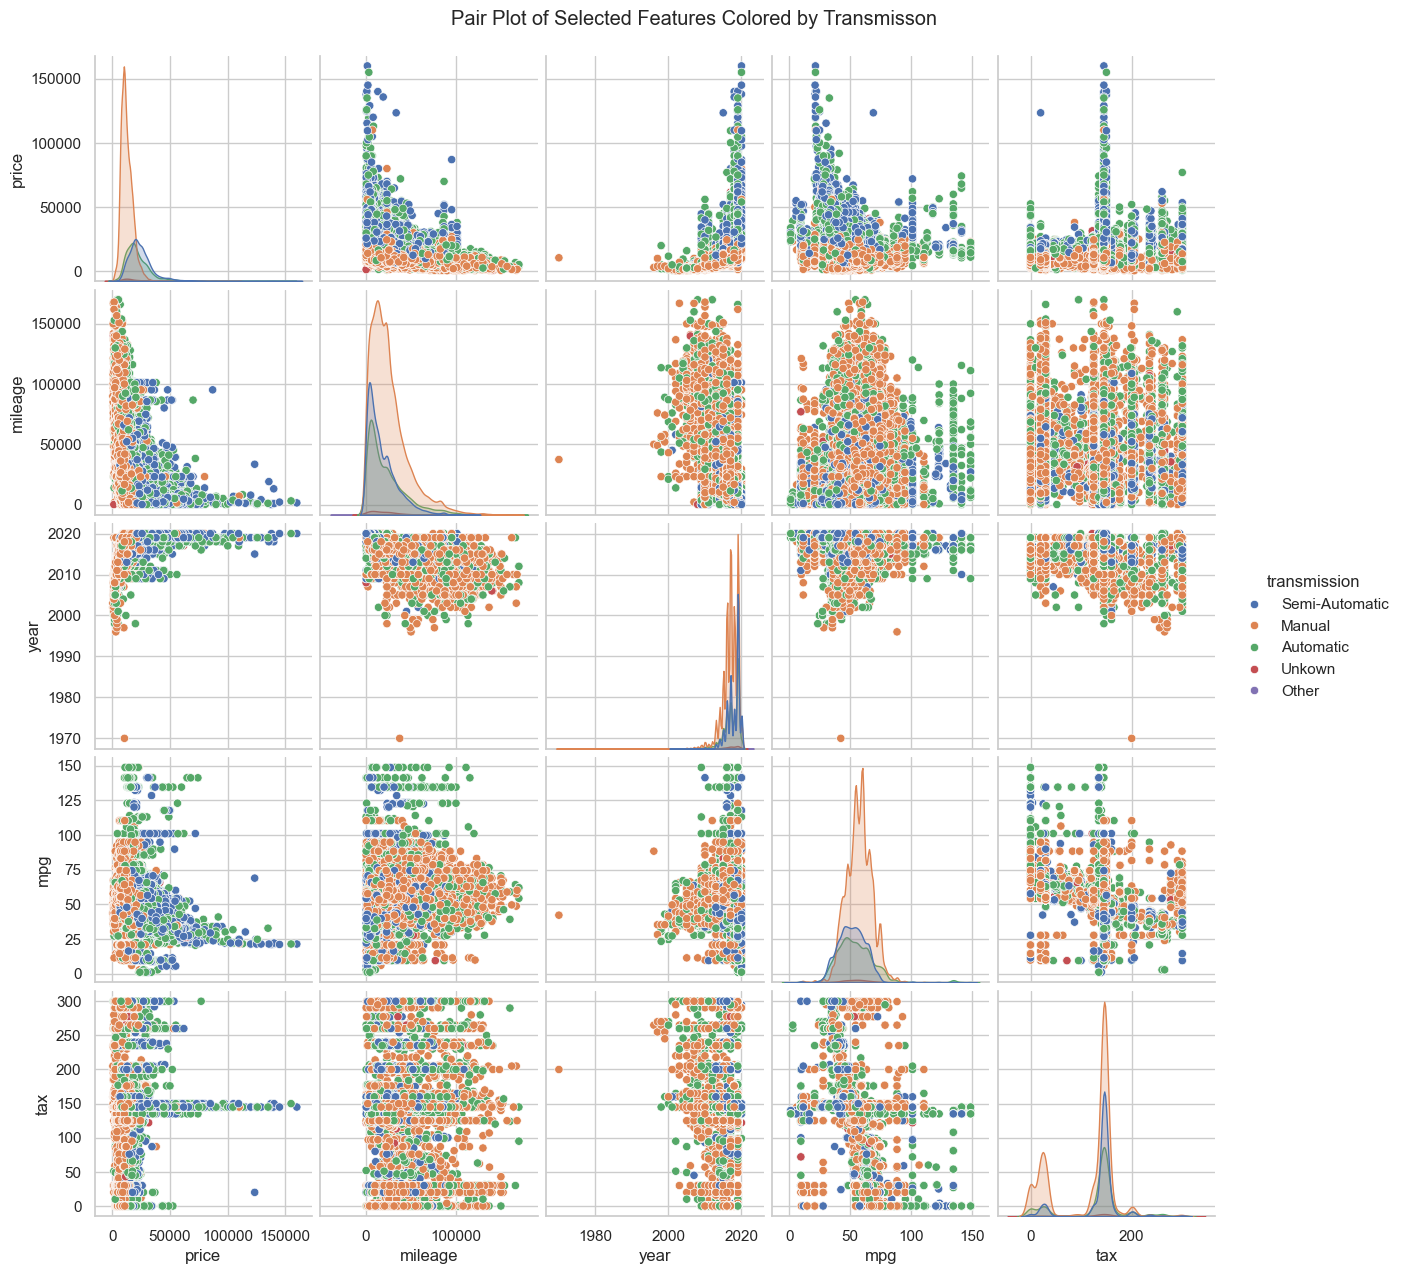

In [530]:
sns.pairplot(train_imputed[['price', 'mileage', 'year', 'mpg', "tax", 'fuelType', "transmission"]], hue='transmission')
plt.suptitle('Pair Plot of Selected Features Colored by Transmisson', y=1.02)
plt.show()

Manual cars are, on average, less expensive, followed by automatic cars, with semi-automatic cars being the most expensive on average. Manual cars also tend to have higher mileage, while automatic and semi-automatic cars have similar mileage distributions. In terms of efficiency, manual cars appear less efficient, with higher mpg values for semi-automatic cars, which are again very similar to automatic cars. 
Tax values are generally similar across transmission types; however, the lower tax range mentioned earlier (0–50) is mostly composed of manual cars, which is reasonable given that the dataset contains mostly manual vehicles however in the higher tax range (100–300), the density of manual, semi-automatic, and automatic cars differs considerably compared to the lower range.

Thus, the composition of transmission types in the lower tax range is very different from that in the higher tax range.

C:\Users\henri\AppData\Local\Temp\ipykernel_22124\2989764192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_imputed['engineSize_bin'] = pd.cut(train_imputed['engineSize'], bins=bins, labels=labels)


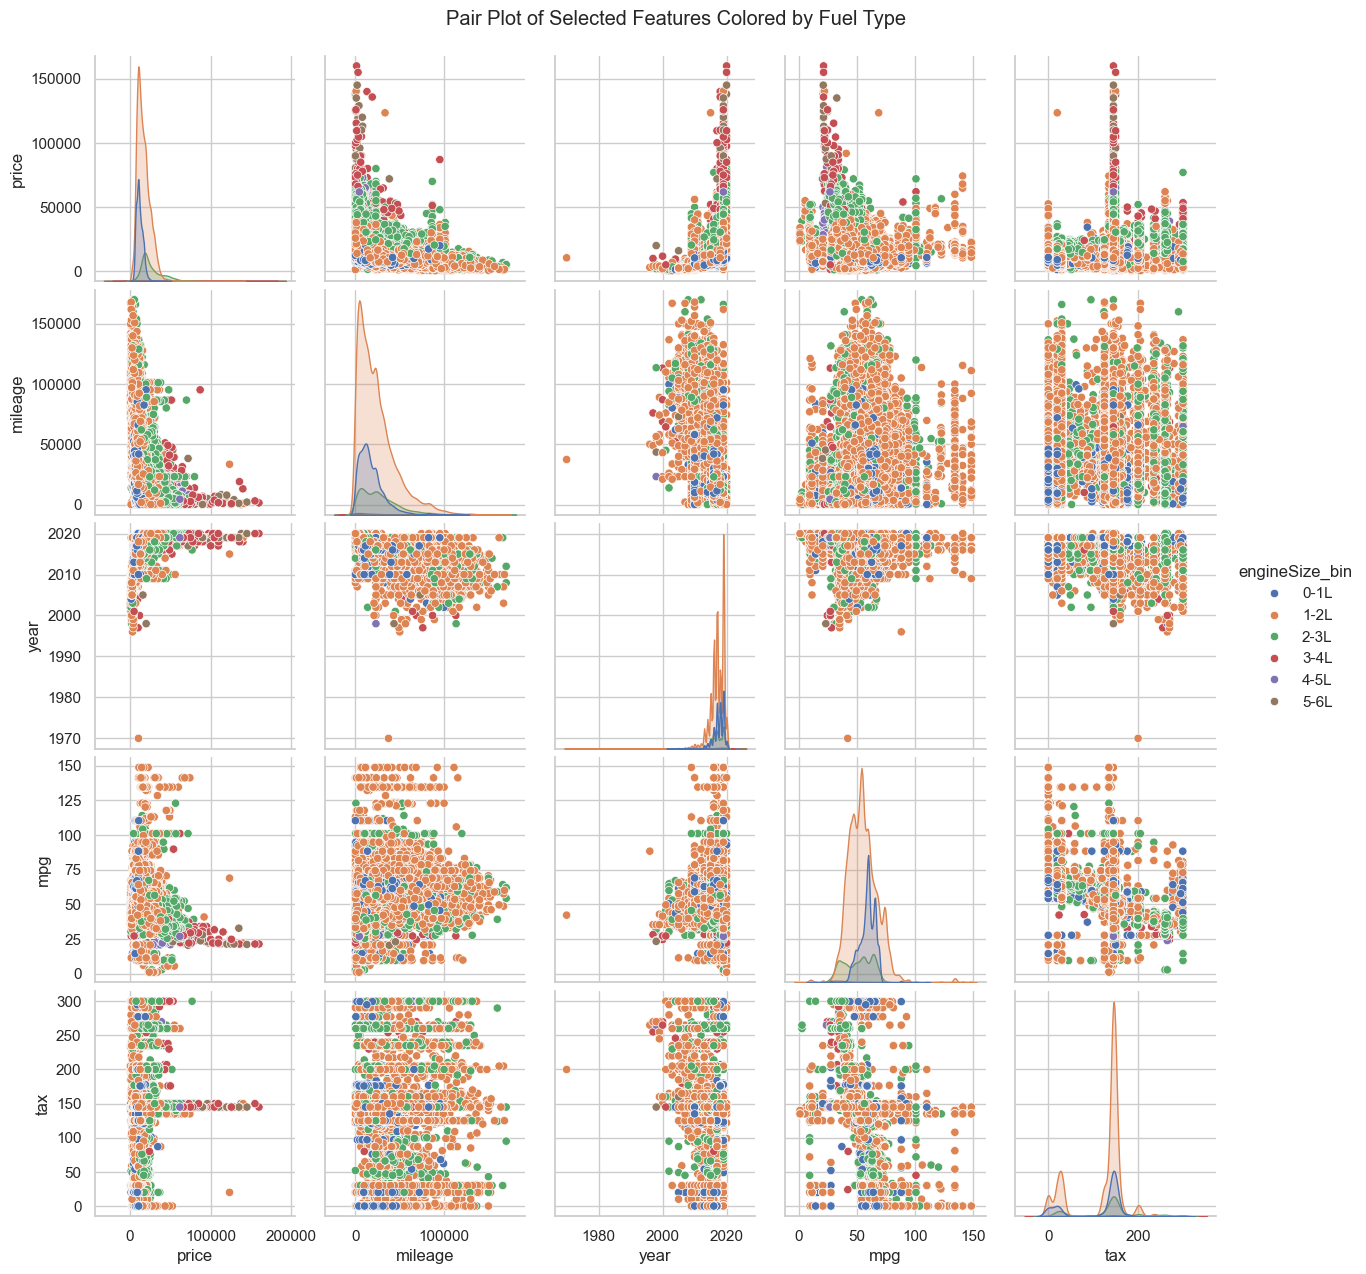

In [531]:
bins = [0, 1, 2, 3, 4, 5, 6]
labels = ['0-1L', '1-2L', '2-3L', '3-4L', '4-5L', '5-6L']
train_imputed['engineSize_bin'] = pd.cut(train_imputed['engineSize'], bins=bins, labels=labels)

sns.pairplot(train_imputed[['price', 'mileage', 'year', 'mpg', "tax", 'fuelType', "engineSize_bin"]], hue='engineSize_bin')
plt.suptitle('Pair Plot of Selected Features Colored by Fuel Type', y=1.02)
plt.show()

The larger the engine size, the higher the price of the vehicle. 

<Axes: >

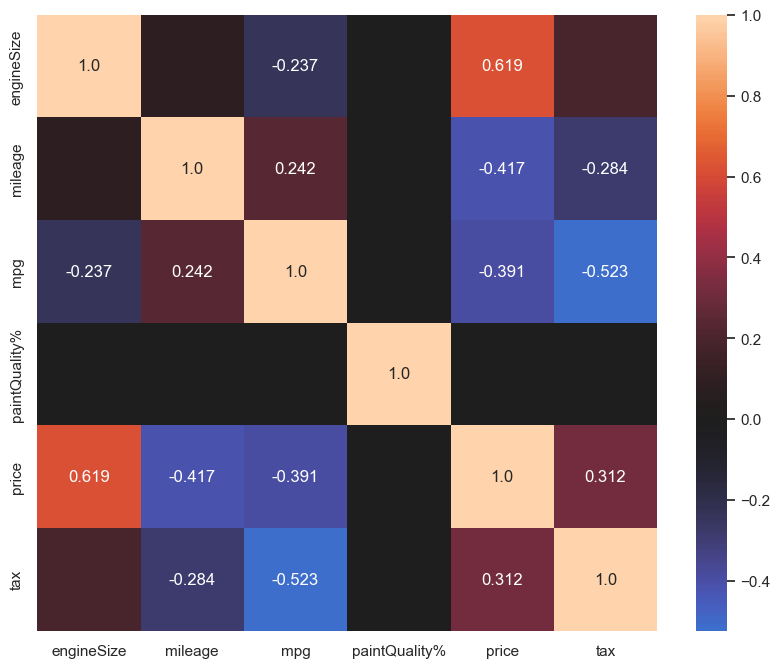

In [532]:
pearson_corr = round(train_imputed[col_n].corr(method="pearson"), 3)

mask_annot = np.absolute(pearson_corr.values) >= 0.2
annot = np.where(mask_annot, pearson_corr.values, np.full(pearson_corr.shape,"")) 

fig = plt.figure(figsize=(10, 8))

sns.heatmap(data=pearson_corr, annot=annot, fmt="", center=0)

There are some moderately strong correlations between the variables. As expected, larger engine sizes are associated with higher prices, while higher mileage is linked to lower prices. Similarly, cars with higher mpg (more efficient) tend to be less expensive. Tax appears to have a negative linear correlation with price.

### Create New Features

In [533]:
def create_newVariables(self):
    df_fe = df_imputed.copy()
    
    # 1. Base Age
    df_fe["age"] = 2022 - df_fe["year"]

    # 2. Existing Ratios with safety check
    df_fe["mileage_per_litre"] = np.where(
        df_fe["engineSize"] != 0,
        df_fe["mileage"] / df_fe["engineSize"],
        0
    )

    df_fe["efficiency_ratio"] = np.where(
        df_fe["engineSize"] != 0,
        df_fe["mpg"] / df_fe["engineSize"],
        0
    )

    """ --- NEW VARIABLES ---

    # 3. Usage Intensity (Is it a fleet/commuter car or a weekend car?)
    # High mileage on a young car usually drops price faster.
    df_fe["mileage_per_year"] = np.where(
        df_fe["age"] > 0,
        df_fe["mileage"] / df_fe["age"],
        df_fe["mileage"] # For cars less than 1 year old
    )

    # 5. Engine Displacement vs Age (The "Classic" vs "Modern Performance" split)
    # Large engines in old cars have a different value curve than large engines in new cars.
    df_fe["engine_age_interact"] = df_fe["engineSize"] * df_fe["age"]

    # 6. Mileage/Age Interaction (Non-linear depreciation)
    # Helps the model see that 50k miles on a 2yr old car is worse than 50k on a 10yr old car.
    df_fe["log_mileage"] = np.log1p(df_fe["mileage"])"""

    return df_fe
    
df_fe = create_newVariables(df_imputed)

In [534]:
col_n_fe, col_c_fe = colTypes(df_fe) 

Numeric Cols: ['age', 'efficiency_ratio', 'engineSize', 'mileage', 'mileage_per_litre', 'mpg', 'paintQuality%', 'price', 'tax', 'year']
Categorical Cols: ['Brand', 'model', 'transmission', 'fuelType', 'previousOwners', 'hasDamage', 'train']


<Axes: >

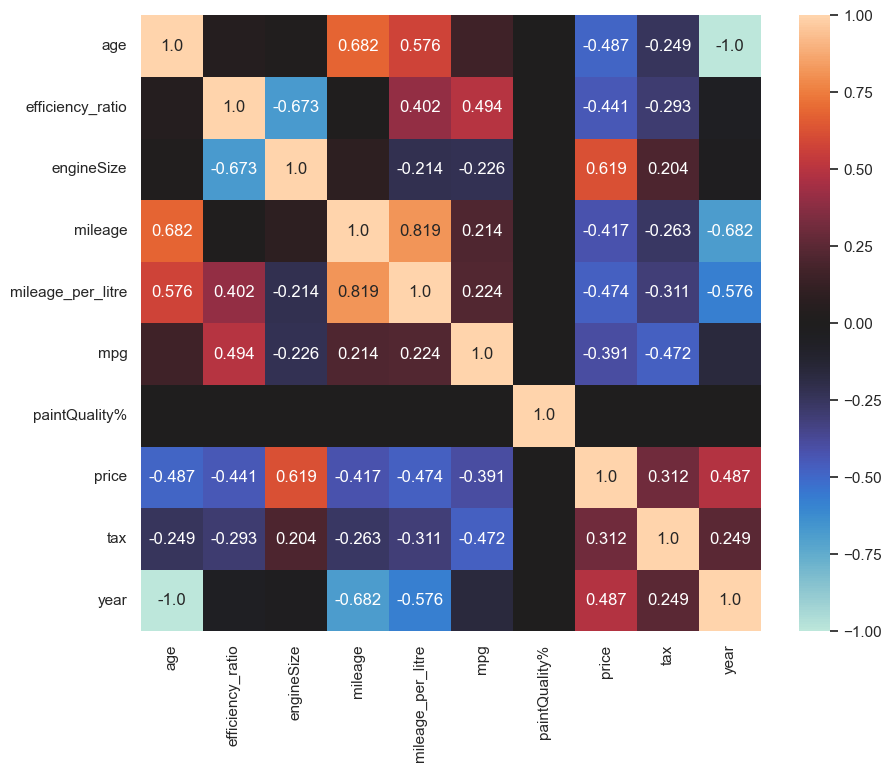

In [535]:
pearson_corr = round(df_fe[col_n_fe].corr(method="pearson"), 3)

mask_annot = np.absolute(pearson_corr.values) >= 0.2
annot = np.where(mask_annot, pearson_corr.values, np.full(pearson_corr.shape,"")) 

fig = plt.figure(figsize=(10, 8))

sns.heatmap(data=pearson_corr, annot=annot, fmt="", center=0)

## 3.6 Scale and Encode Data 

In [536]:
cols_ohe = ["transmission", "fuelType", "previousOwners"] #, "year"] 
cols_imputer_ohe = ["transmission", "fuelType"] #"year"]  
col_target = ["model", "Brand"]
col_n_scale = [col for col in df_fe.columns if col not in cols_ohe + ["hasDamage" , "train", "price"]]
target = ["price"]
col_n_scale

['Brand',
 'model',
 'year',
 'mileage',
 'tax',
 'mpg',
 'engineSize',
 'paintQuality%',
 'age',
 'mileage_per_litre',
 'efficiency_ratio']

In [537]:
filled_df= filled_df.drop(columns=["hasDamage"])

In [538]:
train = filled_df[filled_df["train"] == True]

In [539]:
X = train.drop("price", axis=1)
y = train[target]

In [540]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, 
                                                  random_state = 0, 
                                                  shuffle = True)

In [541]:
X_val["train"] = False

train_idx, val_idx = X_train.index, X_val.index

train_fold = pd.concat([X_train, y_train], axis=1)
val_fold = pd.concat([X_val, y_val], axis=1)

fold_df = pd.concat([train_fold, val_fold], axis=0)

In [542]:
median_imputation_cols, mode_imputation_cols, mean_imputation_cols, cols_ohe, col_n_impute 

(['paintQuality%', 'mpg', 'tax'],
 ['previousOwners', 'transmission', 'year', 'fuelType', 'engineSize'],
 ['mileage'],
 ['transmission', 'fuelType', 'previousOwners'],
 ['mileage', 'engineSize', 'tax', 'mpg'])

In [557]:
%run data_prep.py

In [558]:
config_pipeline = {
    'target_name': 'price',
    'col_n': col_n_impute, 
    'cols_imputer_ohe': cols_imputer_ohe, 
    'mode_imputation_cols': mode_imputation_cols,
    'mean_imputation_cols': mean_imputation_cols,
    'median_imputation_cols': median_imputation_cols,
    'col_target': col_target,
    'cols_ohe': cols_ohe,
    'col_n_scale': col_n_scale,
    "outliers_mask": mask
}

X_train_final, X_val_final, y_train, y_val = preprocess_data(train_fold, val_fold, config_pipeline, False, True)


Outliers removed. New train size: 52525, Test size: 22792


In [ ]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52525 entries, 0 to 75970
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Brand                        52525 non-null  float64
 1   model                        52525 non-null  float64
 2   year                         52525 non-null  float64
 3   mileage                      52525 non-null  float64
 4   tax                          52525 non-null  float64
 5   mpg                          52525 non-null  float64
 6   engineSize                   52525 non-null  float64
 7   paintQuality%                52525 non-null  float64
 8   age                          52525 non-null  float64
 9   mileage_per_litre            52525 non-null  float64
 10  efficiency_ratio             52525 non-null  float64
 11  mileage_per_year             52525 non-null  float64
 12  running_cost_index           52525 non-null  float64
 13  engine_age_interact  

In [559]:
X_train_final

Brand     model      year   mileage   tax       mpg  engineSize  \
carID                                                                       
0      0.836356  0.083542 -0.333333  1.619476 -7.25  1.860140       0.000   
1      0.836356  1.117609  0.000000  0.268882  0.25 -0.076923       1.750   
2      0.836356  0.387401 -0.333333 -0.120176 -1.00 -0.223776      -0.250   
3      0.836356  0.636911  0.000000  0.797164  0.00 -0.356643      -0.250   
4      0.836356  0.653518  0.666667 -0.546751  0.00 -0.601399       0.500   
...         ...       ...       ...       ...   ...       ...         ...   
75963  0.260677  0.658115  0.666667 -0.445869  0.00 -1.000000      -0.125   
75964  0.260677  0.001644 -0.666667  3.264553 -6.25  0.867133       0.000   
75968  0.260677  0.000000 -0.666667  0.294525  0.00 -0.223776      -0.250   
75969  0.260677  0.070255  0.666667 -0.421834  0.00 -1.657343       0.500   
75970  0.260677  0.000000  0.666667 -0.402828  0.00 -0.909091      -0.125   

       paintQuality%       age  mileage_per_litre  ...  transmission_Unkown  \
carID                                              ...                        
0           0.300000  0.333333           1.492952  ...                  0.0   
1          -0.957143  0.000000          -0.227529  ...                  0.0   
2           0.014286  0.333333          -0.069633  ...                  0.0   
3          -0.271429  0.000000           0.922073  ...                  0.0   
4          -0.071429 -0.666667          -0.591665  ...                  0.0   
...              ...       ...                ...  ...                  ...   
75963       0.728571 -0.666667          -0.442527  ...                  0.0   
75964       0.271429  0.666667           3.049086  ...                  0.0   
75968       0.614286  0.666667           0.378687  ...                  0.0   
75969       0.900000 -0.666667          -0.497134  ...                  0.0   
75970       0.442857 -0.666667          -0.399099  ...                  0.0   

       fuelType_Electric  fuelType_Hybrid  fuelType_Other  fuelType_Petrol  \
carID                                                                        
0                    0.0              0.0             0.0              0.0   
1                    0.0              0.0             0.0              0.0   
2                    0.0              0.0             0.0              1.0   
3                    0.0              0.0             0.0              1.0   
4                    0.0              0.0             0.0              0.0   
...                  ...              ...             ...              ...   
75963                0.0              0.0             0.0              1.0   
75964                0.0              0.0             0.0              0.0   
75968                0.0              0.0             0.0              1.0   
75969                0.0              0.0             0.0              0.0   
75970                0.0              0.0             1.0              0.0   

       previousOwners_1.0  previousOwners_2.0  previousOwners_3.0  \
carID                                                               
0                     0.0                 0.0                 0.0   
1                     0.0                 0.0                 0.0   
2                     0.0                 0.0                 0.0   
3                     1.0                 0.0                 0.0   
4                     0.0                 0.0                 0.0   
...                   ...                 ...                 ...   
75963                 0.0                 0.0                 0.0   
75964                 0.0                 1.0                 0.0   
75968                 0.0                 1.0                 0.0   
75969                 0.0                 1.0                 0.0   
75970                 0.0                 0.0                 0.0   

       previousOwners_4.0  previousOwners_6.0  
carID              

# 4. Feature Selection 

In [560]:
# Embedded method with Lasso Regression
lasso_reg = LassoCV()

lasso_reg.fit(X_train_final, y_train)

coefficient = pd.Series(lasso_reg.coef_, index = X_train_final.columns)

print(coefficient.sort_values())
important_features = [coef for coef, val in coefficient.items() if not np.isclose(val, 0.0, atol=1e-6)]
print("Important features:", important_features)

features_to_discard = [coef for coef, val in coefficient.items() if np.isclose(val, 0.0, atol=1e-6)]
print("Features to discard:", features_to_discard)

mileage_per_year              -0.882602
Brand                          0.000000
previousOwners_3.0            -0.000000
previousOwners_2.0             0.000000
previousOwners_1.0             0.000000
fuelType_Petrol               -0.000000
fuelType_Other                 0.000000
fuelType_Hybrid                0.000000
fuelType_Electric             -0.000000
transmission_Unkown           -0.000000
transmission_Semi-Automatic    0.000000
transmission_Other            -0.000000
transmission_Manual           -0.000000
efficiency_ratio              -0.000000
mileage_per_litre             -0.000000
age                           -0.000000
paintQuality%                  0.000000
engineSize                     0.000000
mpg                           -0.000000
tax                            0.000000
mileage                       -0.000000
year                           0.000000
model                          0.000000
previousOwners_4.0            -0.000000
previousOwners_6.0             0.000000


In [ ]:
# 1. Initialize the estimator
rf = RandomForestRegressor(n_estimators=15, random_state=42, n_jobs=-1)

# 2. Initialize RFE
# n_features_to_select: How many features you want to keep
# step: How many features to remove at each iteration (set to 1 for precision)
selector = RFE(estimator=rf, n_features_to_select=15, step=1)

# 3. Fit the selector
selector = selector.fit(X_train_final, y_train)

# 4. Check which features survived
selected_features = X_train_final.columns[selector.support_]
print(f"Selected Features: {selected_features.tolist()}")

# 5. Check the ranking (1 is selected, higher numbers are the order they were dropped)
ranking = dict(zip(X_train_final.columns, selector.ranking_))

Selected Features: ['Brand', 'model', 'year', 'mileage', 'mpg', 'engineSize', 'paintQuality%', 'age', 'mileage_per_litre', 'efficiency_ratio', 'mileage_per_year', 'running_cost_index', 'engine_age_interact', 'log_mileage', 'transmission_Manual']


In [563]:
keep = ['Brand', 
        'model', 
        'year', 
        'mileage', 
        'mpg', 
        'engineSize',  
        'efficiency_ratio', 
        'transmission_Manual', 
        'transmission_Semi-Automatic', 
        'fuelType_Hybrid',
         'fuelType_Petrol']


<hr>
<a class="anchor" id="model_building"></a>

# 5. Model Building and Evaluation

In [ ]:
def evaluation_report(y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    print(f"R²: {r2:.4f} | MAE: {mae:,.2f} | RMSE: {rmse:,.2f}")

In [ ]:
def plot_actual_pred(y_val, val_pred_y):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_val, val_pred_y, alpha=0.6, color='steelblue', edgecolor='k')
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)  # reference line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Random Forest: Predicted vs Actual on Validation Set")
    plt.grid(True)
    plt.show()

def plot_residuals(y_val, y_val_pred):
    residuals = y_val - y_val_pred

    plt.figure(figsize=(8, 6))
    plt.scatter(y_val_pred, residuals, alpha=0.6, color='steelblue', edgecolor='k')
    plt.axhline(0, linestyle='--', linewidth=2)  # reference line at 0
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Random Forest: Residuals vs Predicted (Validation Set)")
    plt.grid(True)
    plt.show()

## Linear Regression

In [565]:
# Modelo OLS
ols = LinearRegression()
ols.fit(X_train_final[keep], y_train)

# Previsões
y_pred_train_ols = ols.predict(X_train_final[keep])
y_pred_val_ols = ols.predict(X_val_final[keep])

# Avaliação
print("TRAIN performance using OLS:")
evaluation_report(y_train, y_pred_train_ols)

print("\nVALIDATION performance using OLS:")
evaluation_report(y_val, y_pred_val_ols)

TRAIN performance using OLS:
R²: 0.7927 | MAE: 2,731.13 | RMSE: 4,394.04

VALIDATION performance using OLS:
R²: 0.7657 | MAE: 2,837.99 | RMSE: 4,710.69


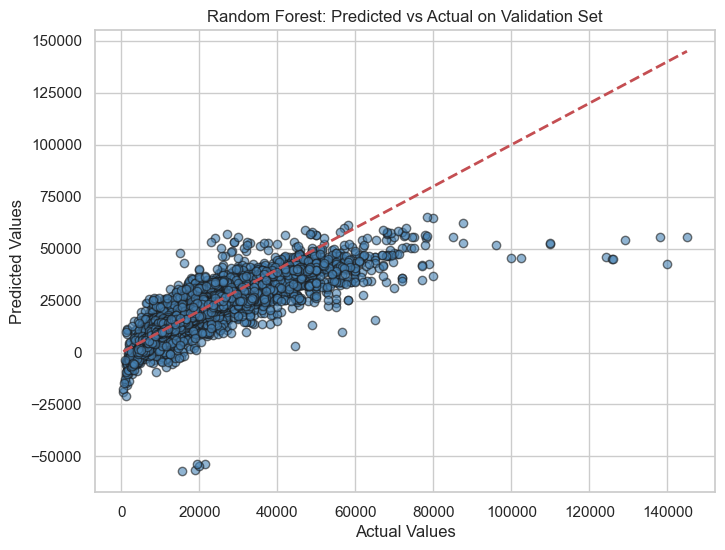

In [566]:
plot_actual_pred(y_val, y_pred_val_ols)

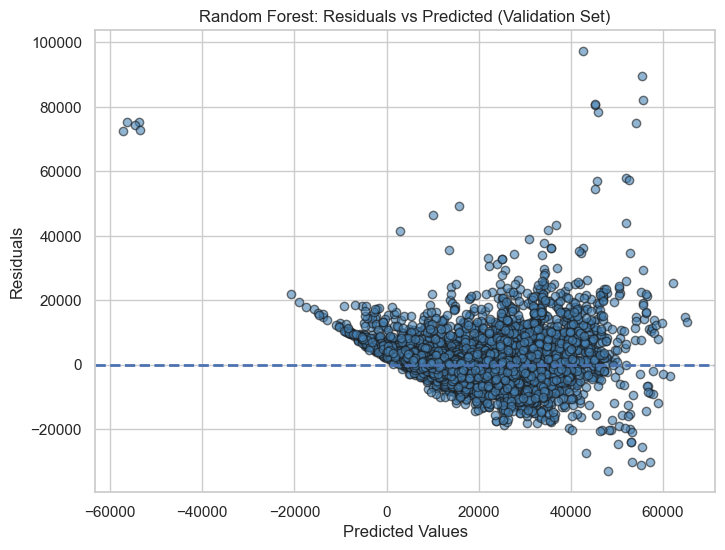

In [567]:
plot_residuals(y_val, y_pred_val_ols)

In [568]:
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [569]:
# Train OLS on log(target)
ols_log = LinearRegression()
ols_log.fit(X_train_final[keep], y_train_log)

# Predictions (LOG scale)
y_pred_train_log_ols = ols_log.predict(X_train_final[keep])
y_pred_val_log_ols = ols_log.predict(X_val_final[keep])

# Back-transform to original scale
y_pred_train_ols = np.expm1(y_pred_train_log_ols)
y_pred_val_ols = np.expm1(y_pred_val_log_ols)

# Evaluation
print("TRAIN performance using LOG-OLS:")
evaluation_report(y_train, y_pred_train_ols)

print("\nVALIDATION performance using LOG-OLS:")
evaluation_report(y_val, y_pred_val_ols)


TRAIN performance using LOG-OLS:
R²: 0.8171 | MAE: 2,357.25 | RMSE: 4,127.08

VALIDATION performance using LOG-OLS:
R²: 0.8126 | MAE: 2,415.55 | RMSE: 4,212.75


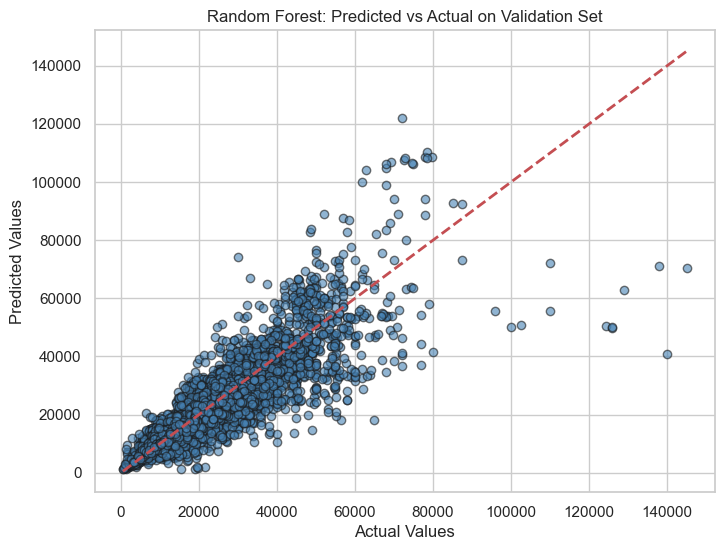

In [570]:
plot_actual_pred(y_val, y_pred_val_ols)

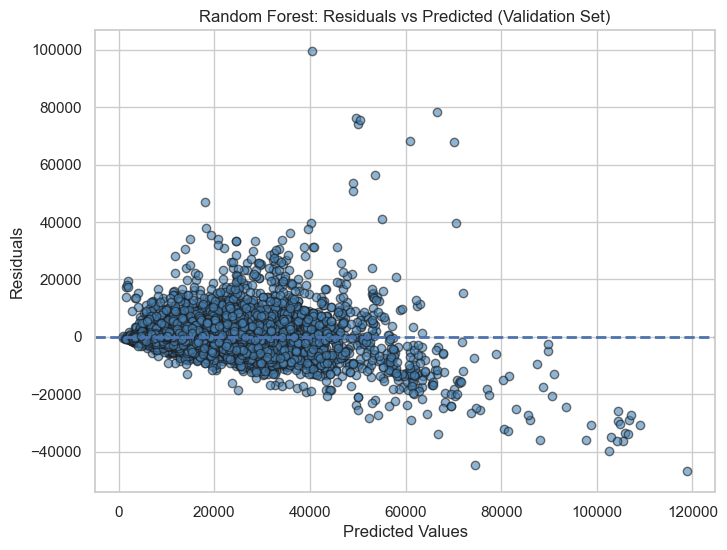

In [ ]:
plot_residuals(y_val, y_pred_val_ols)

## Random Forests

In [ ]:
from sklearn.metrics import mean_squared_error
train_rmse = []
val_rmse = []

# Checking model convergence in training set and validation set. Main Objective: Check for overfitting

# Loop from 1 to 50 trees
for n in range(1, 100):
    model = RandomForestRegressor(
        n_estimators=n,
        random_state=42,
        criterion="squared_error",
        n_jobs=-1
    )
    model.fit(X_train_final[keep], y_train)

    y_train_pred = model.predict(X_train_final[keep])
    y_val_pred = model.predict(X_val_final[keep])

    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    val_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, 100), train_rmse, label="Train RMSE")
plt.plot(range(1, 100), val_rmse, label="Validation RMSE")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("RMSE")
plt.title("Random Forest RMSE vs Number of Trees (1 to 100)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [564]:
RFR = RandomForestRegressor(
    n_estimators=15,
    random_state=42,
    n_jobs=-1, 
)

RFR.fit(X_train_final[keep], y_train_log)

y_train_pred_rf = RFR.predict(X_train_final[keep])
y_val_pred_rf = RFR.predict(X_val_final[keep])

y_train_pred_rf =  np.expm1(y_train_pred_rf)
y_val_pred_rf =  np.expm1(y_val_pred_rf)


print("TRAIN performance using Random Forest Regressor:")
evaluation_report(y_train, y_train_pred_rf)

print("\nVALIDATION performance using Random Forest Regressor:")
evaluation_report(y_val, y_val_pred_rf)

TRAIN performance using Random Forest Regressor:
R²: 0.9878 | MAE: 550.43 | RMSE: 1,063.97

VALIDATION performance using Random Forest Regressor:
R²: 0.9266 | MAE: 1,546.84 | RMSE: 2,635.83


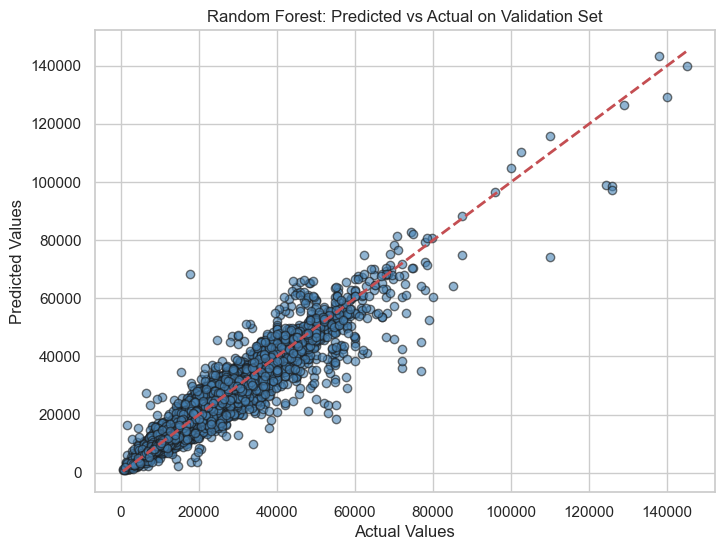

In [ ]:
plot_actual_pred(y_val, y_val_pred_rf)

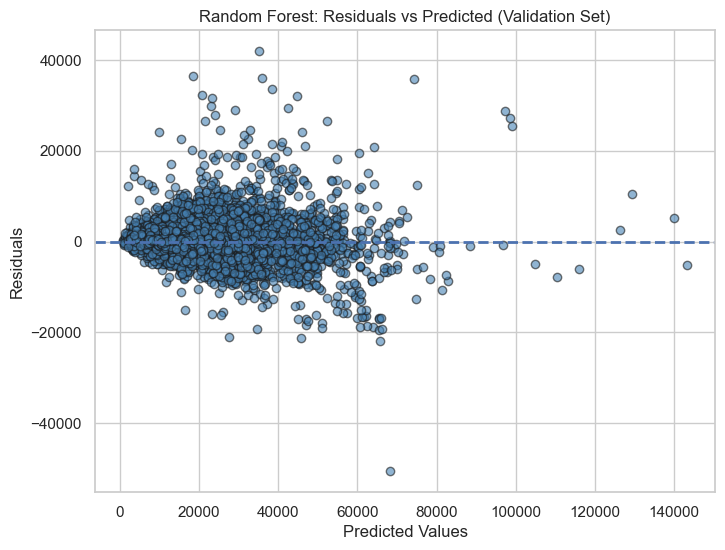

In [ ]:
plot_residuals(y_val, y_val_pred_rf)

In [ ]:
X_val_rf = X_val.copy()

X_val_rf["y"] = y_val
X_val_rf["y_pred"] = y_val_pred_rf
X_val_rf["resid"] = X_val_rf["y"] - X_val_rf["y_pred"]

In [ ]:
X_val_rf.groupby("Brand")[["resid"]].mean()

resid
Brand                 
Audi         35.317674
BMW          60.438902
Ford         88.596850
Hyundai      58.660119
Mercedes     11.191681
Opel         91.921400
Skoda       136.259953
Toyota      174.126255
Volkswagen  -23.525731

In [ ]:
X_val_rf[X_val_rf["resid"] < -40000]

Brand model    year transmission  mileage fuelType   tax   mpg  \
carID                                                                  
4837   Audi    A3  2013.0       Manual  79000.0   Petrol  30.0  57.6   

       engineSize  paintQuality%  previousOwners  train        y  \
carID                                                              
4837          1.2           81.0             4.0  False  17650.0   

             y_pred         resid  
carID                              
4837   68251.648585 -50601.648585

In [ ]:
model_bias = (
    X_val_rf
    .groupby("model")
    .agg(
        mean_resid=("resid", "mean"),
        median_resid=("resid", "median"),
        count=("resid", "size"),
        mae=("resid", lambda x: x.abs().mean())
    )
    .sort_values("mean_resid")
)

# modelos com mais observações
model_bias = model_bias[model_bias["count"] >= 20]

# piores 10 (overestimation)
model_bias.head(10)

# melhores 10 (underestimation)
model_bias.tail(10)

mean_resid  median_resid  count          mae
model                                                  
Touran     423.853026    -95.301466     71  1758.535014
Karoq      429.507208   -167.167932     66  1804.751612
Grandland  449.653751     53.439129    109  1687.560732
RAV4       463.329150    102.070666     97  1435.909822
A6         466.108120    100.626061    142  1694.148853
X4         485.711409   -255.259113     43  1784.522130
C-HR       523.052239    -29.101266     98  1636.734302
A5         528.585485    156.258854    165  1856.468508
B-MAX      650.367229    -32.176936     66  2148.542352
Corolla    993.609180     50.034111     44  1921.849741

In [ ]:
model_bias.head(10)

mean_resid  median_resid  count          mae
model                                                 
IONIQ    -652.719870   -324.441031     69  1447.565455
Verso    -565.042862   -220.045518     31  1946.335274
Avensis  -487.138156   -164.361720     26  2279.738877
X5       -436.348639   -284.256756     88  1431.514875
Scala    -413.149031   -111.491712     46  1993.092373
T-Roc    -378.246100   -357.670653    130  1456.753441
X3       -299.217677   -234.862771    111  1692.043178
Touareg  -296.817809   -408.089080     78  1270.623298
V-Class  -288.370334   -212.139604     35  1532.661469
5 Series -222.219848   -108.175746    224  1817.542574

C:\Users\henri\AppData\Local\Temp\ipykernel_22124\876608849.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(model_bias['count'][i]+1, model_bias['mae'][i], model, fontsize=9)


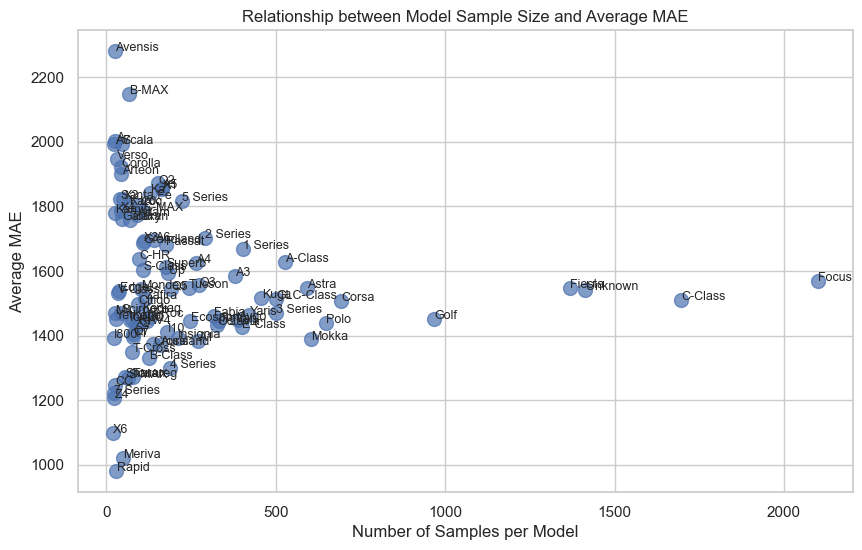

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(model_bias['count'], model_bias['mae'], s=100, alpha=0.7)

# Annotate each point with the model name
for i, model in enumerate(model_bias.index):
    plt.text(model_bias['count'][i]+1, model_bias['mae'][i], model, fontsize=9)

plt.xlabel("Number of Samples per Model")
plt.ylabel("Average MAE")
plt.title("Relationship between Model Sample Size and Average MAE")
plt.grid(True)
plt.show()

In [ ]:
X_combined = np.concatenate([X_train_final[keep], X_val_final[keep]])
y_combined = np.concatenate([y_train, y_val])
test_fold = [-1] * len(X_train) + [0] * len(X_val)

ps = PredefinedSplit(test_fold=test_fold)

from sklearn.model_selection import RandomizedSearchCV

In [ ]:
RFR = RandomForestRegressor(random_state=42, verbose=1)

param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'max_samples': [None, 0.7, 0.9],
    'ccp_alpha': [0.0, 0.001, 0.01],
}

clf_new = RandomizedSearchCV(
    estimator=RFR,
    param_distributions=param_grid,
    n_iter=15,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

clf_new.fit(X_combined, y_combined)

# Print all results
means = clf_new.cv_results_['mean_test_score']
stds = clf_new.cv_results_['std_test_score']

best_mae = float("inf")
for i, (mean, std, params) in enumerate(zip(means, stds, clf_new.cv_results_['params'])):
    mae = -mean
    if mae < best_mae:
        best_mae = mae
    print(f"Iteration {i+1}/{len(means)} | MAE: {mae:.2f} (+/- {std:.2f}) | Best MAE so far: {best_mae:.2f} | Params: {params}")


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Iteration 1/15 | MAE: 1607.85 (+/- 187.18) | Best MAE so far: 1607.85 | Params: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9, 'max_features': 'log2', 'max_depth': 20, 'ccp_alpha': 0.001}
Iteration 2/15 | MAE: 1854.15 (+/- 149.80) | Best MAE so far: 1607.85 | Params: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': None, 'max_features': 'sqrt', 'max_depth': 10, 'ccp_alpha': 0.01}
Iteration 3/15 | MAE: 1854.16 (+/- 165.92) | Best MAE so far: 1607.85 | Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.7, 'max_features': 'sqrt', 'max_depth': 10, 'ccp_alpha': 0.001}
Iteration 4/15 | MAE: 1617.51 (+/- 189.96) | Best MAE so far: 1607.85 | Params: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.9, 'max_features': 'log2', 'max_depth': 30, 'ccp_alpha': 0.001}
Iteration 5/15 | MAE:

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.0s finished


In [ ]:
rf_model = clf_new.best_estimator_
rf_model

RandomForestRegressor(max_depth=20, max_features='log2', max_samples=0.9,
                      min_samples_split=10, n_estimators=50, random_state=42,
                      verbose=1)

In [ ]:
# Fit on the training set (after RandomizedSearchCV, best_estimator_ is already refitted by default)
# If refit=True in RandomizedSearchCV, this step is optional
rf_model.fit(X_train_final[keep], y_train)

# Predict
y_train_pred = rf_model.predict(X_train_final[keep])
y_val_pred   = rf_model.predict(X_val_final[keep])

# Evaluate
print("TRAIN performance using Random Forest Regressor:")
evaluation_report(y_train, y_train_pred)

print("\nVALIDATION performance using Random Forest Regressor:")
evaluation_report(y_val, y_val_pred)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


TRAIN performance using Random Forest Regressor:
R²: 0.9645 | MAE: 1,054.06 | RMSE: 1,817.43

VALIDATION performance using Random Forest Regressor:
R²: 0.9253 | MAE: 1,547.98 | RMSE: 2,659.82


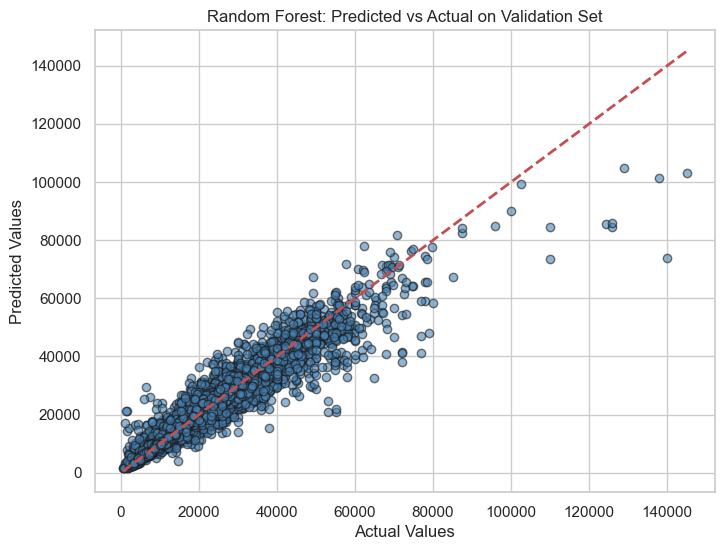

In [ ]:
plot_actual_pred(y_val, y_val_pred)

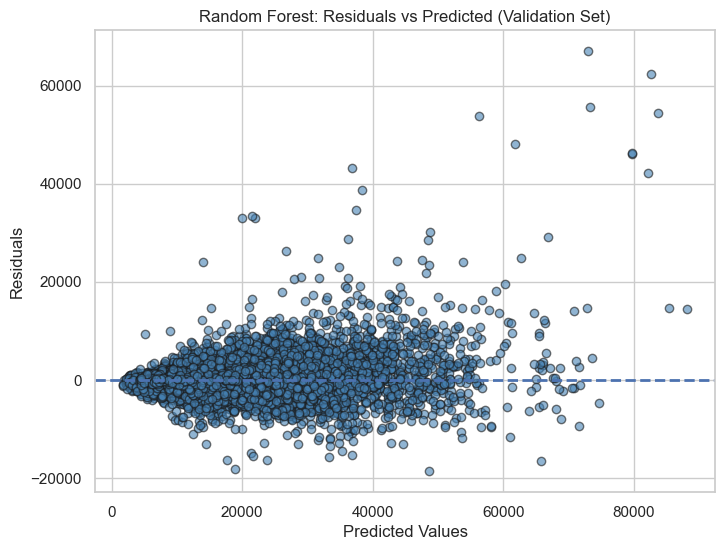

In [ ]:
plot_residuals(y_val, y_val_pred)

In [ ]:
train_fold = df_no_outliers[df_no_outliers["train"] == True]
val_fold = df_no_outliers[df_no_outliers["train"] == False]

In [ ]:
X_train_final, X_test_final, y_train, y_test = preprocess_data(train_fold, val_fold, config_pipeline)

C:\Users\henri\Desktop\Uni\master\ML\Projetos\ML_Project\data_prep.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold["train"] = True
C:\Users\henri\Desktop\Uni\master\ML\Projetos\ML_Project\data_prep.py:340: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold["train"] = False


Outliers removed. New train size: 74968, Test size: 32567


In [ ]:
rf_model = clf_new.best_estimator_

# Fit the model on the new dataset
rf_model.fit(X_train_final[keep], y_train)

# Predict on training data
y_pred_train_best = rf_model.predict(X_train_final[keep])

print("TRAIN performance using Tuned Random Forest Regressor:")
evaluation_report(y_train, y_pred_train_best)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


TRAIN performance using Tuned Random Forest Regressor:
R²: 0.9674 | MAE: 1,022.17 | RMSE: 1,717.05


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished


In [ ]:
y_pred_test = rf_model.predict(X_test_final[keep])

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [ ]:
X_test_final= X_test_final.reset_index()

In [ ]:
kaggle_submission = pd.DataFrame()
kaggle_submission["carID"] = X_test_final["carID"]
kaggle_submission["price"] = y_pred_test
kaggle_submission

carID         price
0       75973  10176.959158
1       75974  21430.471941
2       75975  26145.653174
3       75976  25321.906546
4       75977  14841.932114
...       ...           ...
32562  108535  12875.715226
32563  108536  10290.286174
32564  108537  18217.780970
32565  108538  15653.169488
32566  108539   8638.152980

[32567 rows x 2 columns]

In [ ]:
kaggle_submission.to_csv("kaggle_submission.csv", index=False)